In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

import numpy as np

In [2]:

def plot_inertia(
    df,
    partionning_space="true_proba_error",
    n_samples_train=None,
    n_samples_test=None,
    cluster_value=None,
    seed_test=None,
):
    """
    Two‐panel plot: 
    – Left:  FPR_train vs Inertia
    – Right: FPR_val   vs Inertia

    On each panel we plot all seeds’ scatter and overlay
    a single overall least‐squares line. Legends are removed.
    """
    # filter once
    df_c = df[
        (df['clustering_n_clusters'] == cluster_value) &
        (df['data_n_samples_train'] == n_samples_train) &
        df['inertia'].notnull() &
        df['fpr_train'].notnull() &
        df['fpr_val'].notnull() &
        (df['data_seed_test'] == seed_test) &
        (df["data_n_samples_test"] == n_samples_test) &
        (df['clustering_name'] == "kmeans") &
        (df["clustering_space"] == partionning_space)
    ]
    print(df_c)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)
    y_cols = ['fpr_train', 'fpr_val']
    y_labels = ['FPR (train)', 'FPR (validation)']

    # for each subplot
    for ax, y_col, y_lab in zip(axes, y_cols, y_labels):
        # scatter per‐seed
        for seed in sorted(df_c['clustering_seed'].unique()):
            sub = df_c[df_c['clustering_seed'] == seed].sort_values('inertia')
            ax.plot(
                sub['inertia'],
                sub[y_col],
                marker='o',
                linestyle='',
                alpha=0.5
            )

        # overall LS fit
        x_all = df_c['inertia'].values
        y_all = df_c[y_col].values
        if len(x_all) >= 2:
            m, b = np.polyfit(x_all, y_all, 1)
            x_fit = np.linspace(x_all.min(), x_all.max(), 100)
            ax.plot(
                x_fit,
                m * x_fit + b,
                linestyle='-',
                linewidth=2,
                color='black'
            )

        ax.set_xlabel('Inertia')
        ax.set_ylabel(y_lab)
        ax.grid(True)

    fig.suptitle(f'n_clusters={cluster_value}, n_samples_train={n_samples_train}')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    plt.close()



def plot_experiment_histograms(experiment_dfs,
                               score_col='val_detector_preds',
                               label_col='val_detector_labels',
                               labels=('No error', 'Error'),
                               bins=60):
    """
    Plots normalized-frequency histograms of `score_col` for label=False vs label=True
    for each experiment DataFrame in `experiment_dfs`.

    Parameters
    ----------
    experiment_dfs : dict[str, pd.DataFrame]
        Mapping from experiment name to its predictions DataFrame.
    score_col : str
        Column name of the score/prediction.
    label_col : str
        Column name of the boolean true label.
    labels : tuple[str, str]
        (label for False, label for True)
    bins : int
        Number of histogram bins.
    """
    n = len(experiment_dfs)
    fig, axes = plt.subplots(1, n, figsize=(6*n, 5), sharey=True)
    if n == 1:
        axes = [axes]

    for ax, (exp_name, df) in zip(axes, experiment_dfs.items()):
        # compute common bin edges
        all_scores = df[score_col]
        bin_edges = np.linspace(all_scores.min(), all_scores.max(), bins)

        # split scores by label
        scores_0 = df.loc[~df[label_col], score_col]
        scores_1 = df.loc[df[label_col],  score_col]

        # plot
        ax.hist(scores_0, bins=bin_edges, density=True, alpha=0.5, label=labels[0])
        ax.hist(scores_1, bins=bin_edges, density=True, alpha=0.5, label=labels[1])

        ax.set_title(exp_name)
        ax.set_xlabel('Detecttion Score')
        if ax is axes[0]:
            ax.set_ylabel('Normalized Frequency')
        ax.legend(title='True Label')
        ax.grid(True)

    plt.tight_layout()
    plt.show()

def plot_fpr_2(
    df,
    method="uniform",
    partionning_space="gini",
    cluster_values=None,
    init_scheme=None,
    seed_test=None,
    n_samples_train_inf=None,
    n_samples_train_sup=None,
    ylim=None,  # new argument: e.g. (0.0, 0.1)
):
    # ---- SETUP FIGURE ----
    n_values = len(cluster_values)
    fig, axes = plt.subplots(1, n_values, figsize=(14, 5), sharey=True)
    fig.suptitle(f"{method} partition on {partionning_space}")
    if n_values == 1:
        axes = [axes]
    for ax, cluster_value in zip(axes, cluster_values):
        # 1) Filter for this cluster
        df_c = df[
            (df['clustering_n_clusters'] == cluster_value) &
            (df['data_n_samples_train'] >= n_samples_train_inf) &
            (df['data_n_samples_train'] <= n_samples_train_sup) &
            df['fpr_val'].notnull() &
            (df['data_seed_test'] == seed_test) &
            (df['clustering_name'] == method) &
            (df['clustering_space'] == partionning_space )&
             (df['clustering_init_scheme'] == init_scheme )
        ]
        # 2) Scatter/line for each seed_train
        for seed_train in sorted(df_c['data_seed_train'].unique()):
            df_s = df_c[df_c['data_seed_train'] == seed_train].sort_values('data_n_samples_train')
            ax.plot(
                df_s['data_n_samples_train'],
                df_s['fpr_val'],
                marker='o',
                linestyle='-',
                alpha=0.6,
                label=f"seed {seed_train}"
            )
        
        # 3) Compute mean & std at each n_samples_train
        stats = (
            df_c
            .groupby('data_n_samples_train')['fpr_val']
            .agg(['mean', 'std'])
            .reset_index()
        )
        # ax.hlines(gini_experiment["fpr_val"].item(), xmin=n_samples_train_inf, xmax=n_samples_train_sup,
        #         color="red", linestyle="--", label="Gini Detector FPR")
        # 4) Plot mean line
        ax.plot(
            stats['data_n_samples_train'],
            stats['mean'],
            color='black',
            linewidth=2,
            label='Mean'
        )
        # 5) Shade ±1 STD
        ax.fill_between(
            stats['data_n_samples_train'],
            stats['mean'] - stats['std'],
            stats['mean'] + stats['std'],
            color='gray',
            alpha=0.3,
            label='±1 STD'
        )
        
        # 6) Decorations
        ax.set_title(f'n_clusters = {cluster_value}')
        ax.set_xlabel('n_samples_train')
        if ax is axes[0]:
            ax.set_ylabel('FPR (validation)')
        ax.grid(True)
        ax.set_xlim(n_samples_train_inf, n_samples_train_sup)
        
        # 7) Apply y-axis limits if provided
        if ylim is not None:
            ax.set_ylim(ylim)
        
        ax.legend(title='Seed_train', bbox_to_anchor=(1.02, 1), loc='upper left')

    plt.tight_layout()
    plt.show()
    plt.close()

def plot_fpr_method_comparison(
    df,
    cluster_values,
    seed_test,
    n_samples_train_inf,
    n_samples_train_sup,
    ylim=None,  # e.g. (0.0, 0.1)
):
    """
    Plots FPR curves for two methods ("uniform" vs "kmeans") across different numbers of clusters.
    
    Parameters
    ----------
    df : pandas.DataFrame
        Must contain columns ['n_clusters','n_samples_train','fpr_val','seed_test','seed_train','method'].
    cluster_values : list of int
        The distinct n_clusters to plot (one row per cluster).
    seed_test : int
        The seed_test value to filter for.
    n_samples_train_inf : int
        Minimum n_samples_train to include.
    n_samples_train_sup : int
        Maximum n_samples_train to include.
    ylim : tuple or None
        y‐axis limits (min, max); if None, auto‐scaled.
    """
    methods = ["uniform", "kmeans"]
    n_values = len(cluster_values)
    
    fig, axes = plt.subplots(
        nrows=n_values,
        ncols=2,
        figsize=(14, 5 * n_values),
        sharey=True
    )
    
    # Add column headers
    for j, method in enumerate(methods):
        axes[0, j].set_title(f"{method.capitalize()} method", fontsize=14, pad=20)
    
    for i, cluster_value in enumerate(cluster_values):
        for j, method in enumerate(methods):
            ax = axes[i, j]
            
            # 1) Filter for cluster & method
            df_c = df[
                (df["clustering_n_clusters"] == cluster_value) &
                (df["data_n_samples_train"] >= n_samples_train_inf) &
                (df["data_n_samples_train"] <= n_samples_train_sup) &
                df["fpr_val"].notnull() &
                (df["data_seed_test"] == seed_test) &
                (df["clustering_name"] == method) &
            (df["clustering_space"].isna())
            ]
            
            # 2) Plot each seed_train
            for seed_train in sorted(df_c["data_seed_train"].unique()):
                df_s = df_c[df_c["data_seed_train"] == seed_train].sort_values("data_n_samples_train")
                ax.plot(
                    df_s["data_n_samples_train"],
                    df_s["fpr_val"],
                    marker="o",
                    linestyle="-",
                    alpha=0.6,
                    label=f"seed {seed_train}"
                )
            
            # 3) Compute mean & std at each n_samples_train
            stats = (
                df_c
                .groupby("data_n_samples_train")["fpr_val"]
                .agg(["mean", "std"])
                .reset_index()
            )
            
            # 4) Plot mean line
            ax.plot(
                stats["data_n_samples_train"],
                stats["mean"],
                color="black",
                linewidth=2,
                label="Mean"
            )
            
            # 5) Shade ±1 STD
            ax.fill_between(
                stats["data_n_samples_train"],
                stats["mean"] - stats["std"],
                stats["mean"] + stats["std"],
                color="gray",
                alpha=0.3,
                label="±1 STD"
            )
            ax.hlines(
                bayes_experiment["fpr_val"].item(),
                xmin=n_samples_train_inf,
                xmax=n_samples_train_sup,
                color="red",
                linestyle="--",
                label="Bayes Detector FPR"
        )
            # 6) Decorations
            ax.set_xlabel("n_samples_train")
            if j == 0:
                ax.set_ylabel("FPR (validation)")
            ax.set_xlim(n_samples_train_inf, n_samples_train_sup)
            if ylim is not None:
                ax.set_ylim(ylim)
            ax.grid(True)
            ax.legend(title="Seed_train", bbox_to_anchor=(1.02, 1), loc="upper left")
            
            # 7) Row title on leftmost plots
            if j == 0:
                ax.text(
                    -0.2, 0.5,
                    f"n_clusters = {cluster_value}",
                    transform=ax.transAxes,
                    rotation=90,
                    va="center",
                    fontsize=12
                )
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    


def plot_fpr(
    df,
    method="uniform",
    cluster_values=None,
    seed_test=None,
    n_samples_train_inf=None,
    n_samples_train_sup=None,
    ylim=None,  # new argument: e.g. (0.0, 0.1)
):
    """
    Plots FPR curves for each seed_train across different n_clusters,
    then adds one shared legend without duplicate entries.
    """
    # ---- SETUP FIGURE ----
    n_values = len(cluster_values)
    fig, axes = plt.subplots(1, n_values, figsize=(14, 5), sharey=True)
    if n_values == 1:
        axes = [axes]
    fig.suptitle(f"Method: {method}")

    for ax, cluster_value in zip(axes, cluster_values):
        # 1) Filter for this cluster
        df_c = df[
            (df['clustering_n_clusters'] == cluster_value) &
            (df['data_n_samples_train'] >= n_samples_train_inf) &
            (df['data_n_samples_train'] <= n_samples_train_sup) &
            df['fpr_val'].notnull() &
            (df['data_seed_test'] == seed_test) &
            (df['clustering_name'] == method) &
            (df["clustering_space"].isna())
        ]

        # 2) Scatter/line for each seed_train
        for seed_train in sorted(df_c['data_seed_train'].unique()):
            df_s = df_c[df_c['data_seed_train'] == seed_train].sort_values('data_n_samples_train')
            ax.plot(
                df_s['data_n_samples_train'],
                df_s['fpr_val'],
                marker='o',
                linestyle='-',
                alpha=0.6,
                label=f"seed {seed_train}"
            )

        # 3) Compute mean & std at each n_samples_train
        stats = (
            df_c
            .groupby('data_n_samples_train')['fpr_val']
            .agg(['mean', 'std'])
            .reset_index()
        )

        # 4) Reference line for Bayes Detector FPR
        ax.hlines(
            bayes_experiment["fpr_val"].item(),
            xmin=n_samples_train_inf,
            xmax=n_samples_train_sup,
            color="red",
            linestyle="--",
            label="Bayes Detector FPR"
        )

        # 5) Plot mean line
        ax.plot(
            stats['data_n_samples_train'],
            stats['mean'],
            color='black',
            linewidth=2,
            label='Mean'
        )

        # 6) Shade ±1 STD
        ax.fill_between(
            stats['data_n_samples_train'],
            stats['mean'] - stats['std'],
            stats['mean'] + stats['std'],
            color='gray',
            alpha=0.3,
            label='±1 STD'
        )

        # 7) Decorations
        ax.set_title(f'n_clusters = {cluster_value}')
        ax.set_xlabel('n_samples_train')
        if ax is axes[0]:
            ax.set_ylabel('FPR (validation)')
        ax.grid(True)
        ax.set_xlim(n_samples_train_inf, n_samples_train_sup)
        if ylim is not None:
            ax.set_ylim(ylim)

    # ——— AFTER THE LOOP: SHARED LEGEND WITHOUT DUPLICATES ———
    # 1) Collect all handles & labels
    all_handles = []
    all_labels = []
    for ax in axes:
        handles, labels = ax.get_legend_handles_labels()
        all_handles.extend(handles)
        all_labels.extend(labels)

    # 2) Remove duplicate labels (preserve order)
    unique = {}
    for h, l in zip(all_handles, all_labels):
        if l not in unique:
            unique[l] = h
    unique_labels = list(unique.keys())
    unique_handles = [unique[l] for l in unique_labels]

    # 3) Add a single legend to the figure
    fig.legend(
        unique_handles,
        unique_labels,
        title="Series",
        loc="upper right",
        bbox_to_anchor=(1.15, 0.9)
    )

    # 4) Make room and finalize
    plt.subplots_adjust(right=0.82)
    plt.tight_layout()
    plt.show()
    plt.close()


def collect_experiment_comparison_data(results_dir):
    """
    Scans the results/experiments directory, reads each experiment folder,
    and collects all configuration parameters along with the mean and std for 
    each accuracy metric (fpr, auc, aurc) from train and test CSV files.
    
    For fpr, the mean is computed as before. The standard deviation for fpr is computed as:
      - If all folds provided a var_fpr value: new_std = sqrt(sum(var_fpr) / (n_fold^2))
      - Otherwise: new_std = standard deviation of the fpr values.
    For auc and aurc, mean and std are computed in the standard way.
    
    Args:
        results_dir (str): Base directory containing the experiments folder.
        
    Returns:
        DataFrame: DataFrame where each row corresponds to an experiment and 
                   columns include all configuration parameters and the computed metrics.
    """
    experiment_dirs = [
        os.path.join(results_dir, d)
        for d in os.listdir(results_dir)
        if os.path.isdir(os.path.join(results_dir, d)) and d.startswith("experiment_")
    ]
    
    records = []
    

    for exp_dir in tqdm(experiment_dirs, desc="Processing experiment directories"):

        record = {}
        config_path = os.path.join(exp_dir, "config.json")
        if not os.path.exists(config_path):
            print(f"Config file not found in {exp_dir}. Skipping...")
            continue
        
        with open(config_path, "r") as f:
            config = json.load(f)
        config = pd.json_normalize(config, sep="_").to_dict(orient="records")[0]
        if config["experiment_folder"] is None:
            config["experiment_folder"] = os.path.basename(exp_dir) 
        record.update(config)
        
                
        # Process test fold CSVs.
        results_path = os.path.join(exp_dir, "detector_results.csv")
        if not os.path.exists(results_path):
            print(f"Results file not found in {results_path}. Skipping...")
            continue
        df = pd.read_csv(results_path)
        row = df.iloc[0]
        record.update(row.to_dict())
  
        
        records.append(record)
    
    if not records:
        print("No experiment records found.")
        return None
    
    df = pd.DataFrame(records)
    if "fpr" in df.columns:
        df.sort_values(by="fpr", inplace=True, na_position="last")
    return df


import matplotlib.pyplot as plt

def plot_fpr_method_comparison_2(
    df,
    cluster_values,
    seed_test,
    n_samples_train_inf,
    n_samples_train_sup,
    clustering_seed = {"kmeans" : 0, "soft-kmeans" : 0},
    clustering_space="true_proba_error",
    methods=["kmeans", "kmeans++"],
    init_scheme = {"kmeans" : "kmeans++", "kmeans++" : "kmeans++"},
    ylim=None  # e.g. (0.0, 0.1)
):
    """
    Plots FPR curves for multiple clustering methods across different numbers of clusters.

    Each subplot corresponds to a value in cluster_values and shows the mean FPR ±1 STD for each method.

    Parameters
    ----------
    df : pandas.DataFrame
        Must contain columns ['clustering_n_clusters', 'data_n_samples_train', 'fpr_val',
        'data_seed_test', 'data_seed_train', 'clustering_name', 'clustering_space'].
    cluster_values : list of int
        The distinct clustering_n_clusters to plot (one subplot per cluster).
    seed_test : int
        The seed_test value to filter for.
    n_samples_train_inf : int
        Minimum n_samples_train to include (x-axis lower bound).
    n_samples_train_sup : int
        Maximum n_samples_train to include (x-axis upper bound).
    methods : list of str
        Clustering methods to compare (e.g., ["uniform", "kmeans"]).
    ylim : tuple or None
        y-axis limits (min, max); if None, auto-scaled.
    """
    n_plots = len(cluster_values)
    fig, axes = plt.subplots(
        nrows=n_plots,
        ncols=1,
        figsize=(10, 5 * n_plots),
        sharex=True,
        sharey=True
    )

    # Ensure axes is iterable
    if n_plots == 1:
        axes = [axes]

    # Loop over clusters
    for ax, cluster_value in zip(axes, cluster_values):
        # Loop over methods
        for method in methods:
            # Filter DataFrame
            df_c = df[
                (df['clustering_n_clusters'] == cluster_value) &
                (df['data_n_samples_train'] >= n_samples_train_inf) &
                (df['data_n_samples_train'] <= n_samples_train_sup) &
                df['fpr_val'].notnull() &
                (df['data_seed_test'] == seed_test) &
                (df['clustering_name'] == method) &
                (df["clustering_space"].eq(partionning_space) 
               | df["clustering_space"].isna()) &
                (df['clustering_init_scheme'] == init_scheme[method]) &
                (df['clustering_seed'] == clustering_seed[method])

            ]
            print(method, len(df_c))
            # Compute mean and std
            stats = (
                df_c
                .groupby('data_n_samples_train')['fpr_val']
                .agg(['mean', 'std'])
                .reset_index()
            )

            # Plot mean curve
            ax.plot(
                stats['data_n_samples_train'],
                stats['mean'],
                marker='o',
                linestyle='-',
                label=f"{method.capitalize()} mean"
            )
            # Shade ±1 STD
            ax.fill_between(
                stats['data_n_samples_train'],
                stats['mean'] - stats['std'],
                stats['mean'] + stats['std'],
                alpha=0.3,
                label=f"{method.capitalize()} ±1 STD"
            )

        # Plot Bayes Detector FPR if available
        try:
            bayes_fpr = bayes_experiment['fpr_val'].item()
            ax.hlines(
                bayes_fpr,
                xmin=n_samples_train_inf,
                xmax=n_samples_train_sup,
                color='red',
                linestyle='--',
                label='Bayes Detector FPR'
            )
        except Exception:
            pass

        # Decorations
        ax.set_title(f"n_clusters = {cluster_value}", fontsize=14)
        ax.set_xlabel("n_samples_train")
        ax.set_ylabel("FPR (validation)")
        ax.set_xlim(n_samples_train_inf, n_samples_train_sup)
        if ylim is not None:
            ax.set_ylim(ylim)
        ax.grid(True)
        ax.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

def plot_fpr_method_comparison_2(
    df,
    cluster_values,
    seed_test,
    n_samples_train_inf,
    n_samples_train_sup,
    clustering_seed={"kmeans": 0, "soft-kmeans": 0},
    clustering_space="true_proba_error",
    methods=["kmeans", "soft-kmeans"],
    init_scheme={"kmeans": "kmeans++", "soft-kmeans": "kmeans++"},
    ylim=None  # e.g. (0.0, 0.1)
):
    """
    Plots FPR curves for multiple clustering methods across different numbers of clusters.

    Subplots are arranged in a grid with 2 columns and enough rows to accommodate all cluster_values.
    Each subplot corresponds to a value in cluster_values and shows the mean FPR ±1 STD for each method.
    """
    n_plots = len(cluster_values)
    n_cols = 2
    n_rows = math.ceil(n_plots / n_cols)

    fig, axes = plt.subplots(
        nrows=n_rows,
        ncols=n_cols,
        figsize=(12, 5 * n_rows),
        sharex=True,
        sharey=True
    )
    axes = axes.flatten()

    for idx, cluster_value in enumerate(cluster_values):
        ax = axes[idx]
        for method in methods:
            df_c = df[
                (df['clustering_n_clusters'] == cluster_value) &
                (df['data_n_samples_train'] >= n_samples_train_inf) &
                (df['data_n_samples_train'] <= n_samples_train_sup) &
                df['fpr_val'].notnull() &
                (df['data_seed_test'] == seed_test) &
                (df['clustering_name'] == method) &
                ((df['clustering_space'] == clustering_space) | df['clustering_space'].isna()) &
                (df['clustering_init_scheme'] == init_scheme[method]) &
                (df['clustering_seed'] == clustering_seed[method])
            ]
            print(method, cluster_value, df_c["data_seed_train"].unique())

            stats = (
                df_c.groupby('data_n_samples_train')['fpr_val']
                    .agg(['mean', 'std'])
                    .reset_index()
            )

            ax.plot(
                stats['data_n_samples_train'],
                stats['mean'],
                marker='o',
                linestyle='-',
                label=f"{method} mean"
            )
            ax.fill_between(
                stats['data_n_samples_train'],
                stats['mean'] - stats['std'],
                stats['mean'] + stats['std'],
                alpha=0.3,
                label=f"{method} ±1 STD"
            )

        try:
            bayes_fpr = bayes_experiment['fpr_val'].item()
            ax.hlines(
                bayes_fpr,
                xmin=n_samples_train_inf,
                xmax=n_samples_train_sup,
                color='red',
                linestyle='--',
                label='Bayes Detector FPR'
            )
        except Exception:
            pass

        ax.set_title(f"n_clusters = {cluster_value}")
        ax.set_xlabel("n_samples_train")
        ax.set_ylabel("FPR (validation)")
        ax.set_xlim(n_samples_train_inf, n_samples_train_sup)
        if ylim is not None:
            ax.set_ylim(ylim)
        ax.grid(True)
        ax.legend(loc='upper right')

    # Hide unused subplots
    for j in range(n_plots, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()



In [ ]:
RESULTS_DIR = "../../synth_results/asymp_exp"
compile_results = True

if compile_results:
    df = collect_experiment_comparison_data(RESULTS_DIR)
    path = os.path.join(RESULTS_DIR, "all_results.csv")
    df.to_csv(path, index=False)


df = collect_experiment_comparison_data(RESULTS_DIR)
if df is None or df.empty:
    print("No data to write to CSV.")
df.head()

Processing experiment directories:   1%|          | 137/15238 [00:00<01:18, 191.74it/s]

Results file not found in ../../synth_results/asymp_exp/experiment_127/detector_results.csv. Skipping...


Processing experiment directories:  17%|█▋        | 2521/15238 [00:14<01:18, 161.65it/s]

Results file not found in ../../synth_results/asymp_exp/experiment_4249/detector_results.csv. Skipping...


Processing experiment directories:  24%|██▎       | 3607/15238 [00:20<01:16, 152.71it/s]

Results file not found in ../../synth_results/asymp_exp/experiment_101/detector_results.csv. Skipping...


Processing experiment directories:  39%|███▉      | 5999/15238 [00:35<01:00, 151.95it/s]

Results file not found in ../../synth_results/asymp_exp/experiment_1576/detector_results.csv. Skipping...


Processing experiment directories:  49%|████▉     | 7441/15238 [00:45<00:43, 179.30it/s]

Results file not found in ../../synth_results/asymp_exp/experiment_43/detector_results.csv. Skipping...


Processing experiment directories:  49%|████▉     | 7477/15238 [00:45<00:45, 172.46it/s]

Results file not found in ../../synth_results/asymp_exp/experiment_6339/detector_results.csv. Skipping...


Processing experiment directories: 100%|██████████| 15238/15238 [01:32<00:00, 164.00it/s]


,data_n_samples_train,data_n_samples_test,data_batch_size_train,data_batch_size_test,data_seed_train,data_seed_test,clustering_name,clustering_n_clusters,clustering_seed,clustering_init_scheme,...,fpr_train,tpr_train,thr_train,fpr_val,tpr_val,thr_val,inertia,clustering_cov_type,clustering_temperature,clustering_normalize_gini
0,8000,100000,100000,100000,0,-1,kmeans,50.0,0.0,k-means++,...,0.634654,0.962227,0.141337,0.700969,0.950032,0.128386,929113.375000,NaN,NaN,NaN
1,14000,100000,100000,100000,4,-1,kmeans,50.0,0.0,k-means++,...,0.755432,0.960362,0.107415,0.757279,0.950032,0.107367,42989.390625,NaN,NaN,NaN
2,500,100000,100000,100000,2,-1,soft-kmeans,20.0,0.0,kmeans++,...,0.134904,0.969697,0.403681,0.171576,0.960977,0.375663,3.237296,spherical,NaN,NaN
3,28000,100000,100000,100000,3,-1,kmeans,100.0,0.0,k-means++,...,0.368208,0.951451,0.049648,0.366248,0.958598,0.049648,19.944914,NaN,NaN,NaN
4,77000,100000,100000,100000,3,-1,uniform,500.0,NaN,None,...,0.166798,0.951185,0.121231,0.152835,0.950825,0.127240,NaN,None,NaN,None


**Variance of FPR w.r.t. $D_{\mathbb{train}}$**

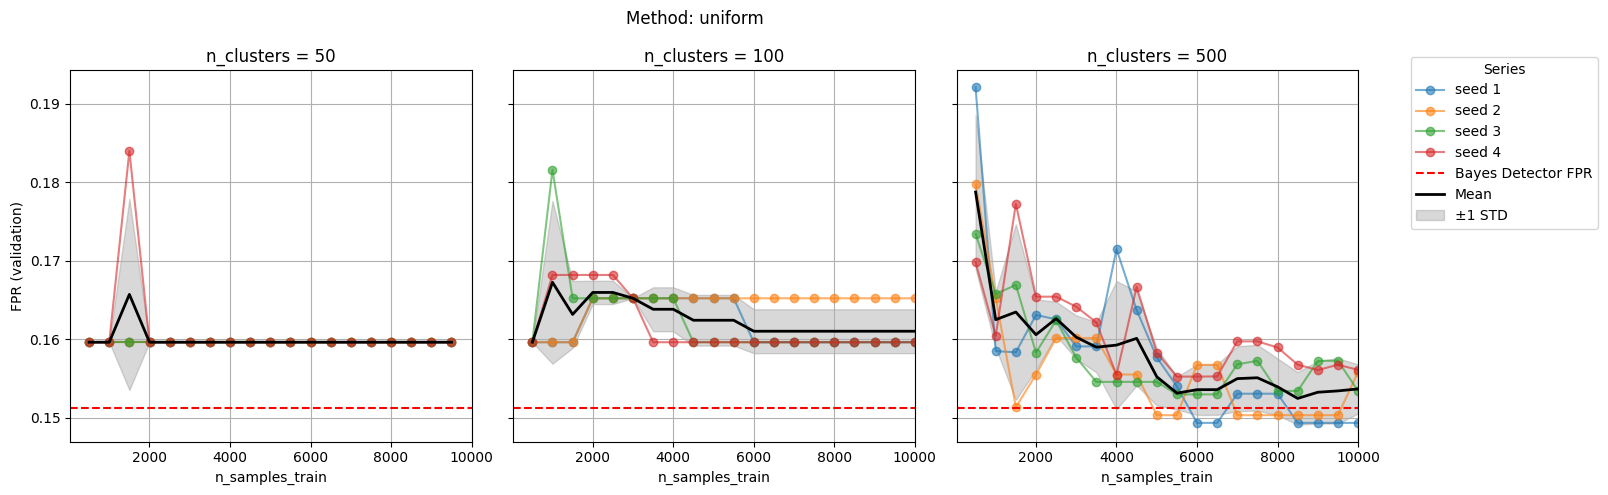

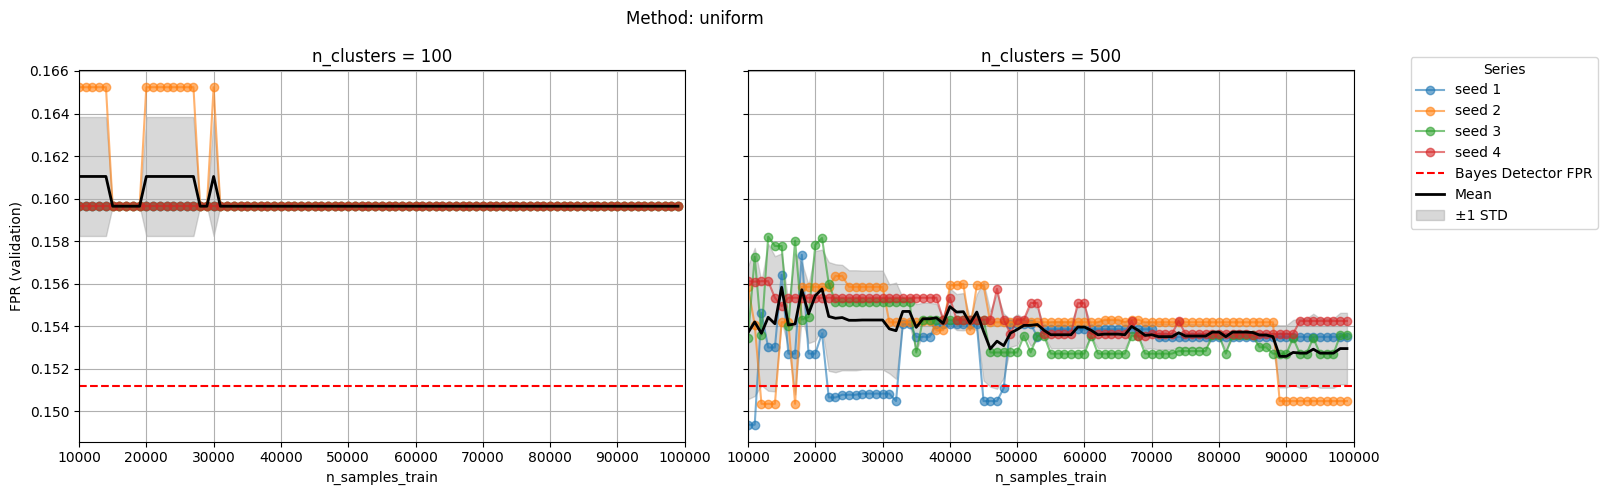

In [83]:
import numpy as np
import matplotlib.pyplot as plt

# ---- PARAMETERS ----
cluster_values      = [50, 100, 500]    # the two n_clusters values you care about
n_samples_train_inf = 30
n_samples_train_sup = 10000
seed_test           = -1
 

plot_fpr(df, cluster_values=cluster_values, seed_test=seed_test, n_samples_train_inf = n_samples_train_inf, n_samples_train_sup = 10000)
plot_fpr(df, seed_test=seed_test, cluster_values = [100, 500], n_samples_train_inf = 10000, n_samples_train_sup = 100000)


**Uniform partionning vs Kmeans**

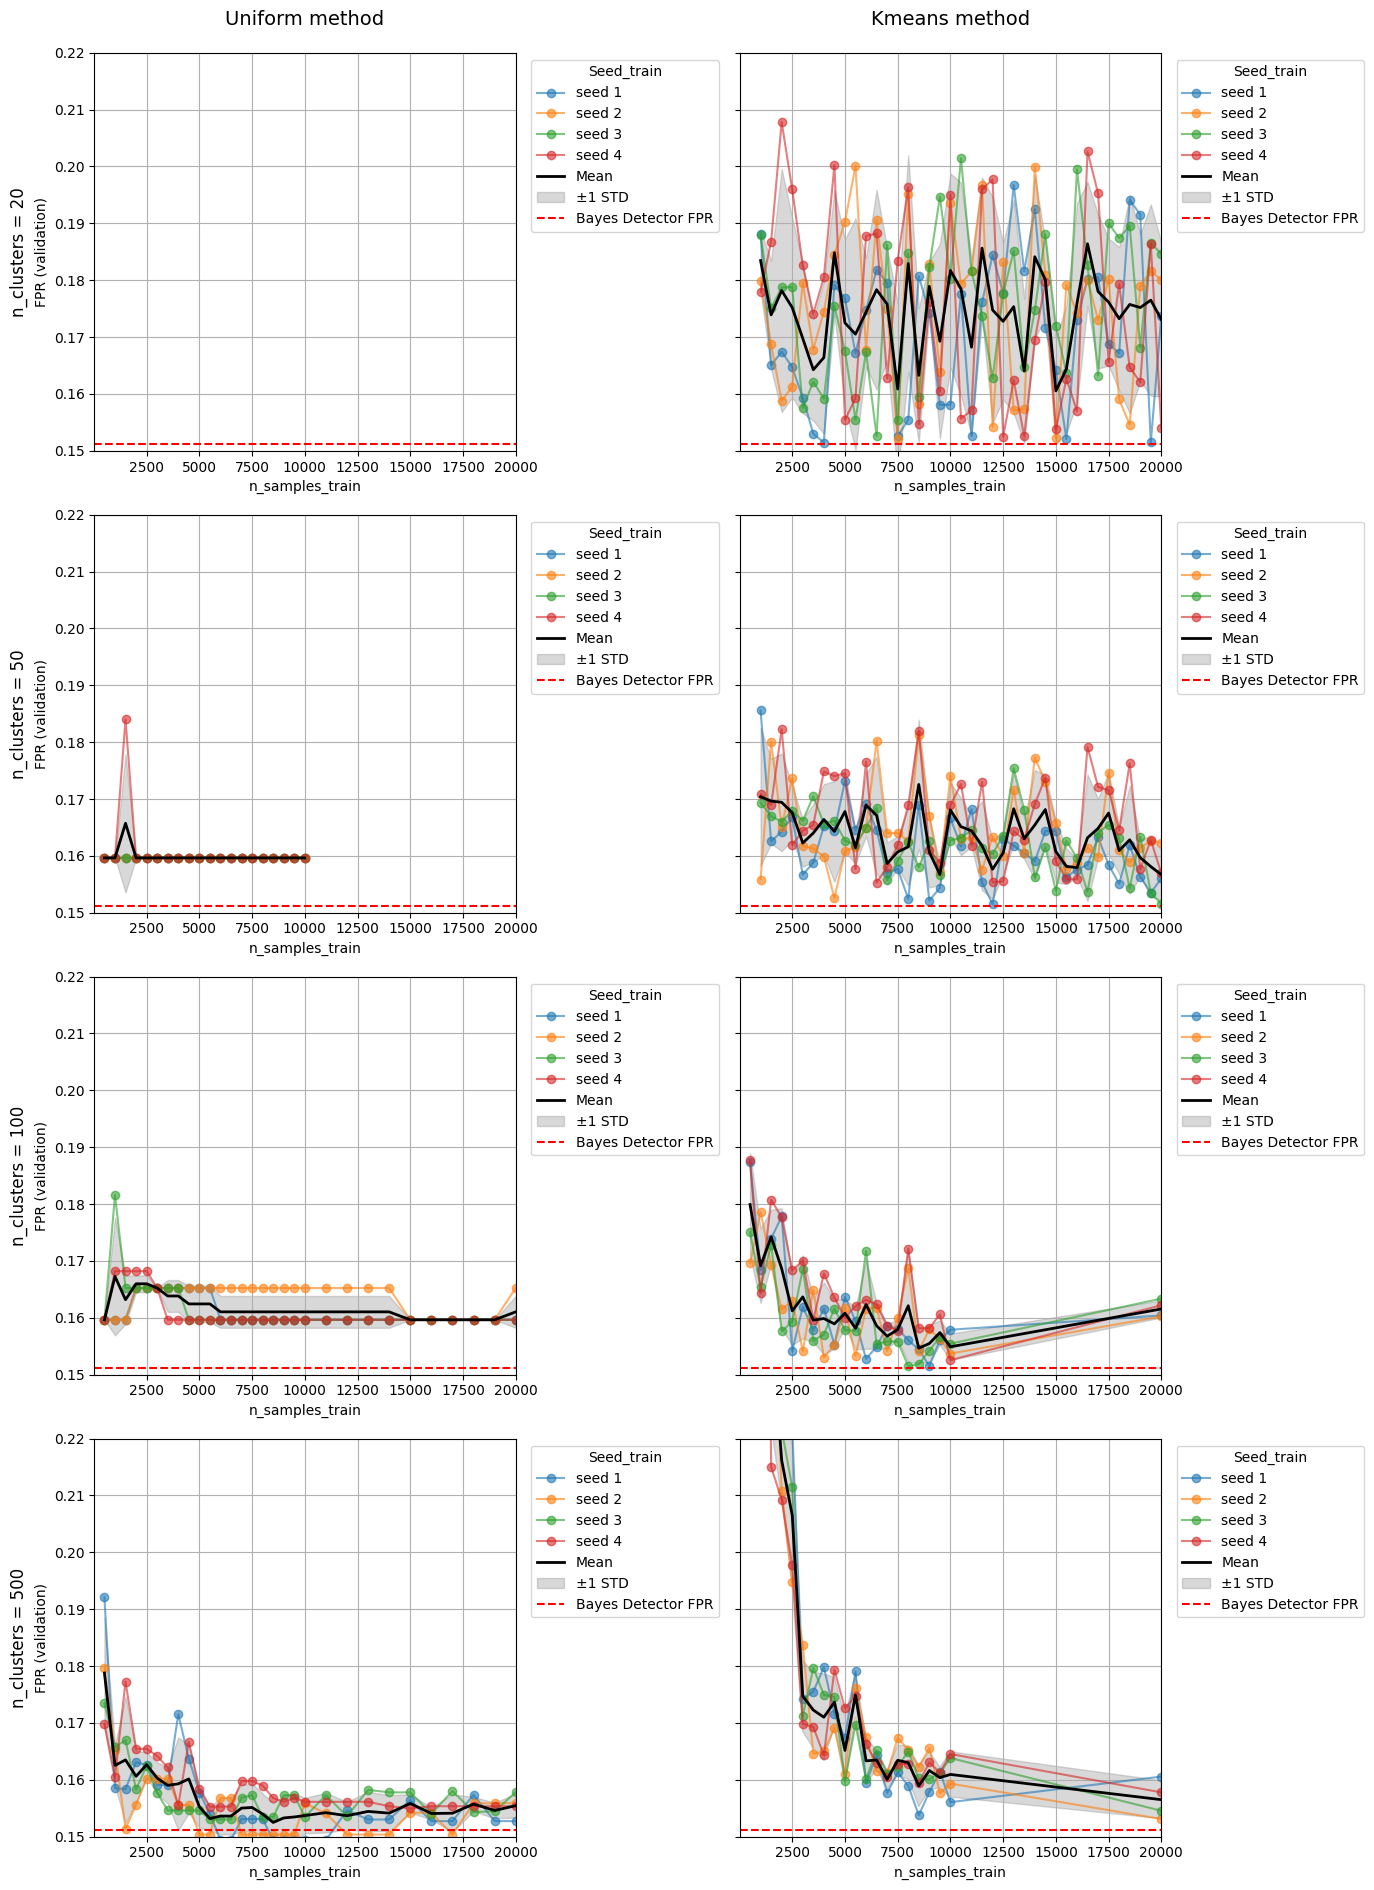

In [60]:

n_samples_train_inf = 20
n_samples_train_sup = 20000
ylim = (0.15, 0.22)
seed_test = -1
plot_fpr_method_comparison(df, cluster_values=[20, 50, 100, 500], seed_test=seed_test,
          n_samples_train_inf = n_samples_train_inf, n_samples_train_sup = n_samples_train_sup,
          ylim=ylim)

**Kmeans works with n_cluster = 10 !!**

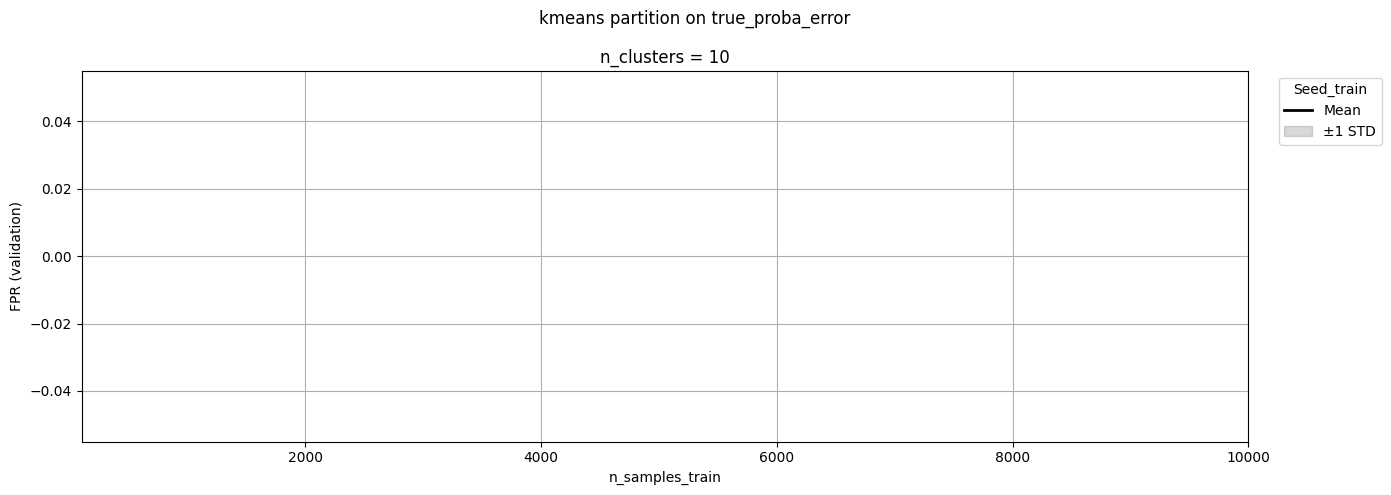

In [181]:
plot_fpr_2(
    df,
    method="kmeans",
    partionning_space="true_proba_error",
    cluster_values = [10],
    n_samples_train_inf=100,
    n_samples_train_sup=10000,
    seed_test=-1)

**Soft-Kmeans**

**Init scheme = "kmeans"**

**init_scheme="kmeans++"**

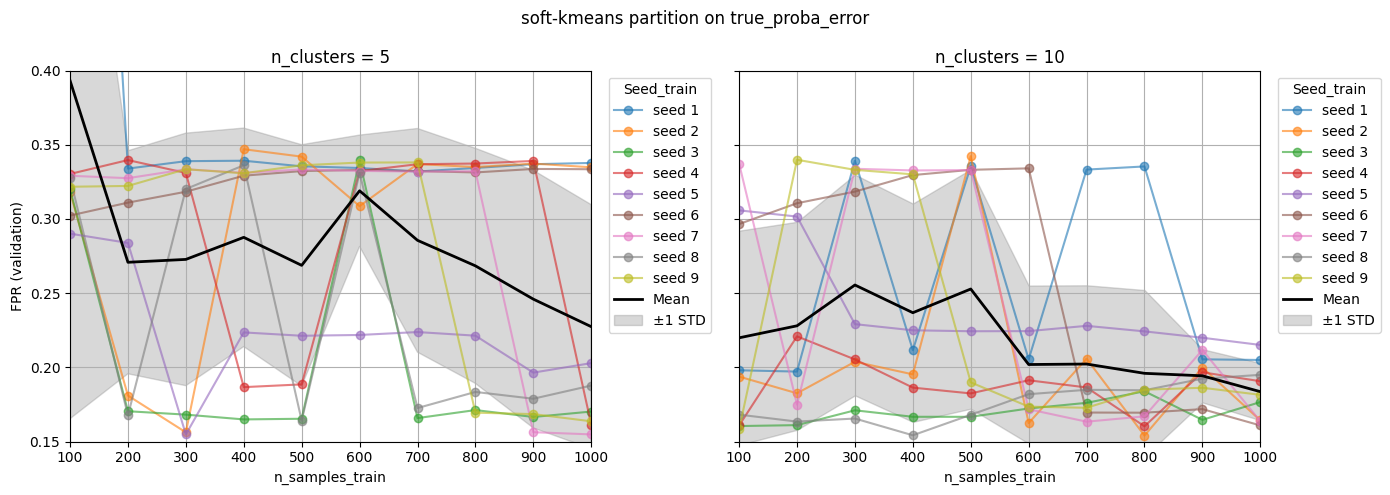

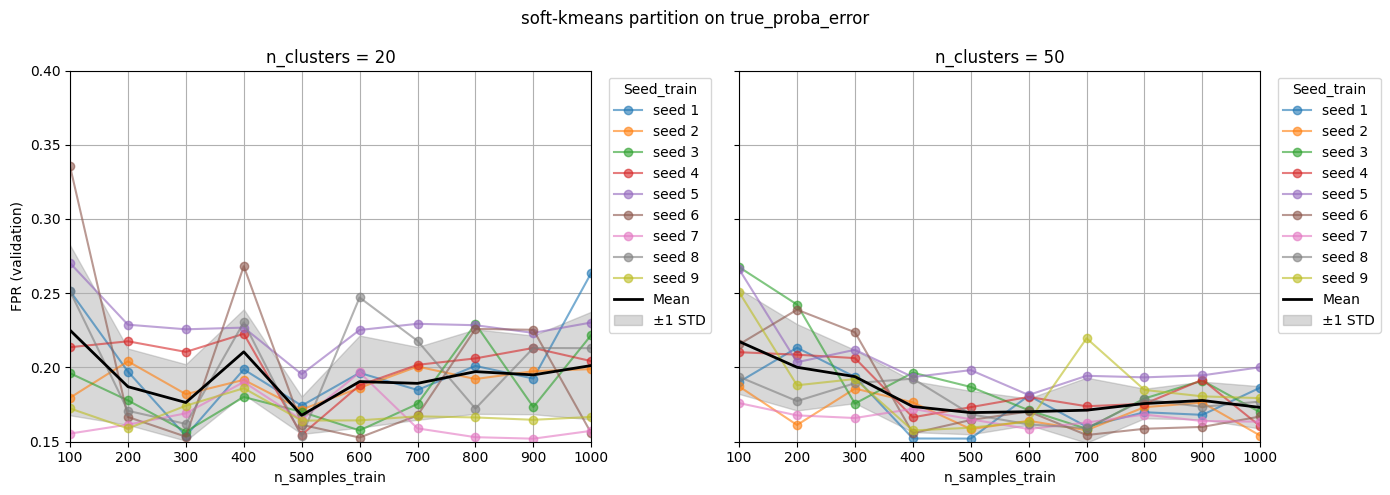

In [216]:
ylim = (0.15, 0.4)
init_scheme="kmeans++"
n_samples_train_inf = 100
n_samples_train_sup = 1000
plot_fpr_2(
    df,
    method="soft-kmeans",
    partionning_space="true_proba_error",
    cluster_values = [5, 10],
    n_samples_train_inf=n_samples_train_inf,
    n_samples_train_sup=n_samples_train_sup,
    seed_test=-1,
    init_scheme=init_scheme,
    ylim=ylim)

plot_fpr_2(
    df,
    method="soft-kmeans",
    partionning_space="true_proba_error",
    cluster_values = [20, 50],
    n_samples_train_inf=n_samples_train_inf,
    n_samples_train_sup=n_samples_train_sup,
    init_scheme=init_scheme,
    seed_test=-1,
    ylim=ylim)

**Comparison kmeans and soft-kmeans**

kmeans 5 [8 3 1 5 2 7 6 4 9]
soft-kmeans 5 [8 2 4 7 9 1 6 5 3]
kmeans 10 [7 8 5 4 6 9 3 1 2]
soft-kmeans 10 [2 5 4 8 9 7 3 1 6]
kmeans 20 [4 1 3 6 2 7 8 5 9]
soft-kmeans 20 [2 9 6 5 7 8 3 4 1]
kmeans 50 [2 8 3 7 1 9 5 4 6]
soft-kmeans 50 [3 1 9 8 7 5 6 2 4]


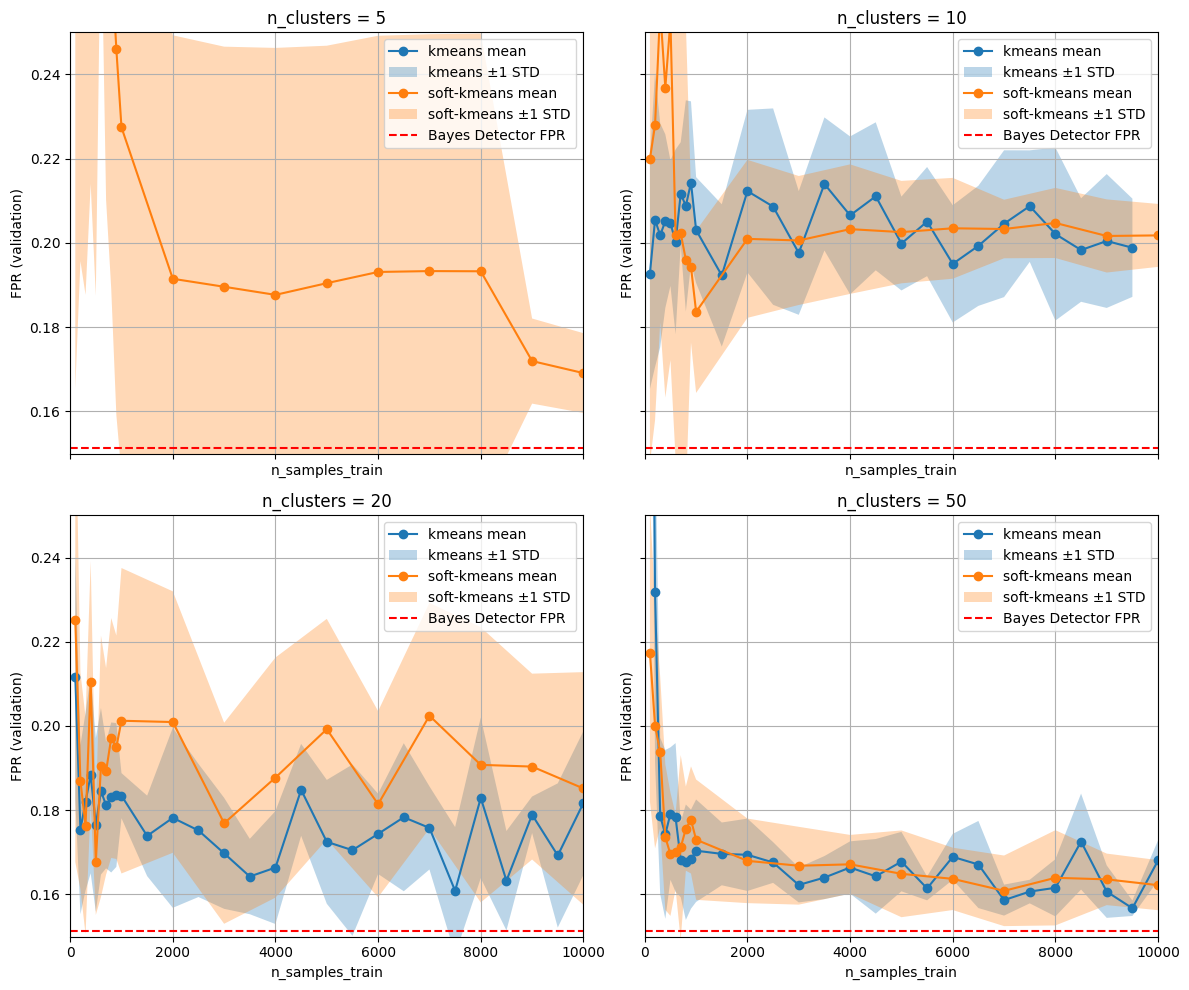

In [194]:
# ---- PARAMETERS ----
cluster_values = [5, 10, 20, 50]
seed_test = -1
ylim = (0.15, 0.25)
init_scheme = {"kmeans" : "k-means++", "soft-kmeans" : "kmeans++"}
n_samples_train_inf = 0
n_samples_train_sup = 10000
clustering_seed = {"kmeans" : 0, "soft-kmeans" : 0}
clustering_space = "true_proba_error"
methods=["kmeans", "soft-kmeans"]


plot_fpr_method_comparison_2(
    df=df,
    cluster_values=cluster_values,
    seed_test=seed_test,
    n_samples_train_inf=n_samples_train_inf,
    n_samples_train_sup=n_samples_train_sup,
    clustering_seed = clustering_seed,
    clustering_space=clustering_space,
    methods=methods,
    init_scheme = init_scheme,
    ylim=ylim  # e.g. (0.0, 0.1)
)


**Clustering space : Probits**

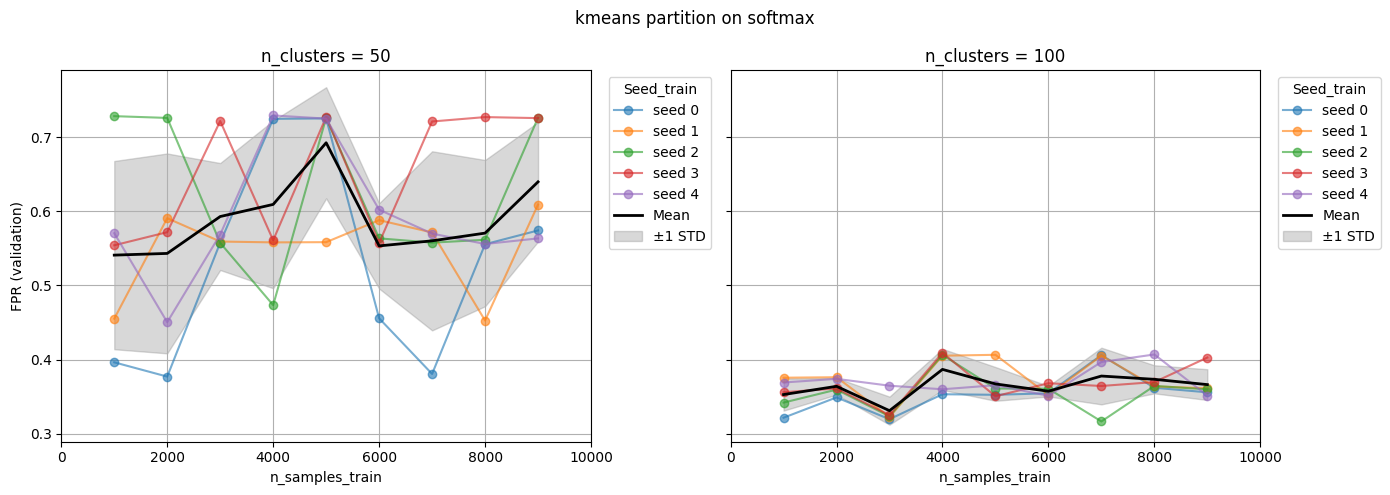

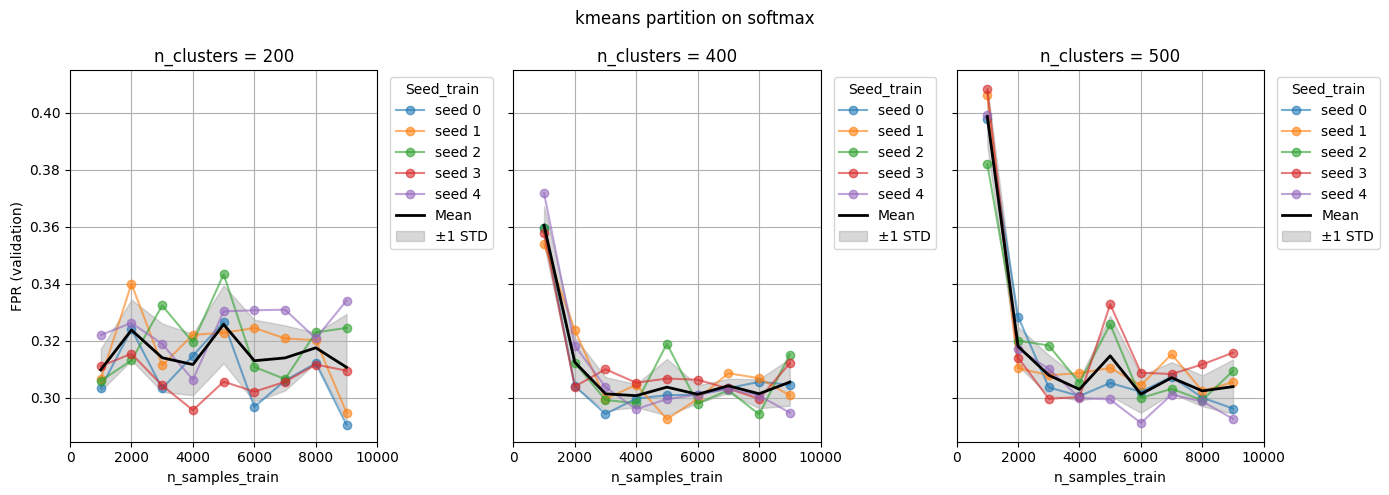

In [78]:
ylim = (0.15, 0.4)
init_scheme="k-means++"
n_samples_train_inf = 0
n_samples_train_sup = 10000

plot_fpr_2(
    df,
    method="kmeans",
    partionning_space="softmax",
    cluster_values = [50, 100],
    n_samples_train_inf=n_samples_train_inf,
    n_samples_train_sup=n_samples_train_sup,
    init_scheme=init_scheme,
    seed_test=-1,
    ylim=None)

plot_fpr_2(
    df,
    method="kmeans",
    partionning_space="softmax",
    cluster_values = [200, 400, 500],
    n_samples_train_inf=n_samples_train_inf,
    n_samples_train_sup=n_samples_train_sup,
    init_scheme=init_scheme,
    seed_test=-1,
    ylim=None)

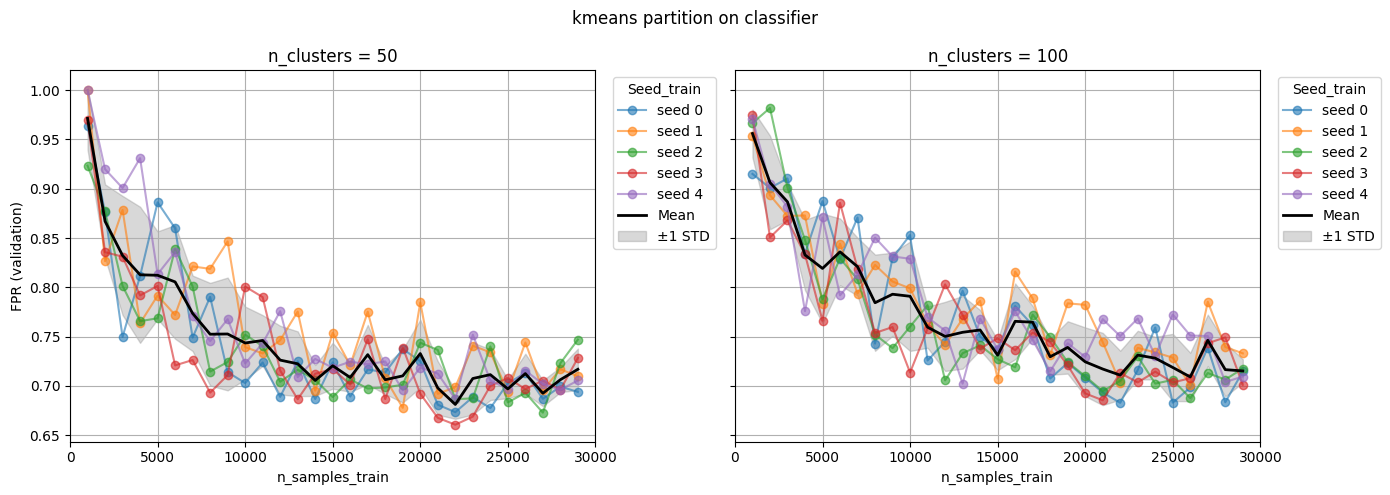

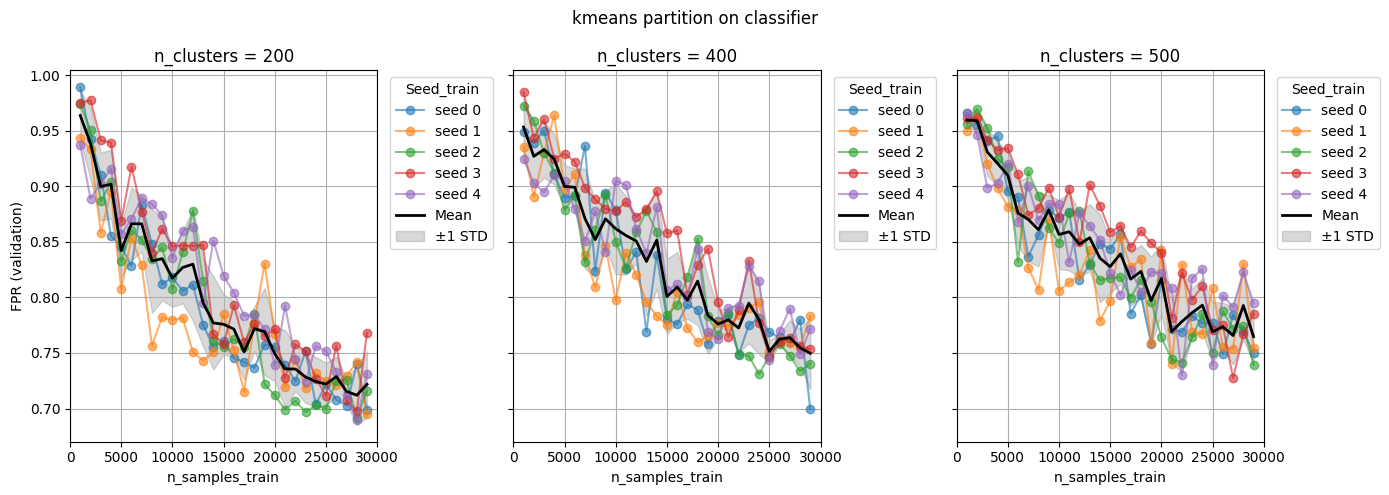

In [13]:
ylim = (0.15, 0.4)
method = "kmeans"
init_scheme="k-means++"
n_samples_train_inf = 0
n_samples_train_sup = 30000
clustering_space = "classifier"

plot_fpr_2(
    df,
    method=method,
    partionning_space=clustering_space,
    cluster_values = [50, 100],
    n_samples_train_inf=n_samples_train_inf,
    n_samples_train_sup=n_samples_train_sup,
    init_scheme=init_scheme,
    seed_test=-1,
    ylim=None)

plot_fpr_2(
    df,
    method=method,
    partionning_space=clustering_space,
    cluster_values = [200, 400, 500],
    n_samples_train_inf=n_samples_train_inf,
    n_samples_train_sup=n_samples_train_sup,
    init_scheme=init_scheme,
    seed_test=-1,
    ylim=None)

**Is Inertia of Kmeans Correlated to FPR ?**

      data_n_samples_train  data_n_samples_test  data_batch_size_train  \
435                  10000              1000000                 100000   
518                  10000              1000000                 100000   
715                  10000              1000000                 100000   
739                  10000              1000000                 100000   
1267                 10000              1000000                 100000   
1281                 10000              1000000                 100000   
1385                 10000              1000000                 100000   
1538                 10000              1000000                 100000   
1704                 10000              1000000                 100000   
1728                 10000              1000000                 100000   
1917                 10000              1000000                 100000   
1967                 10000              1000000                 100000   
2000                 10000            

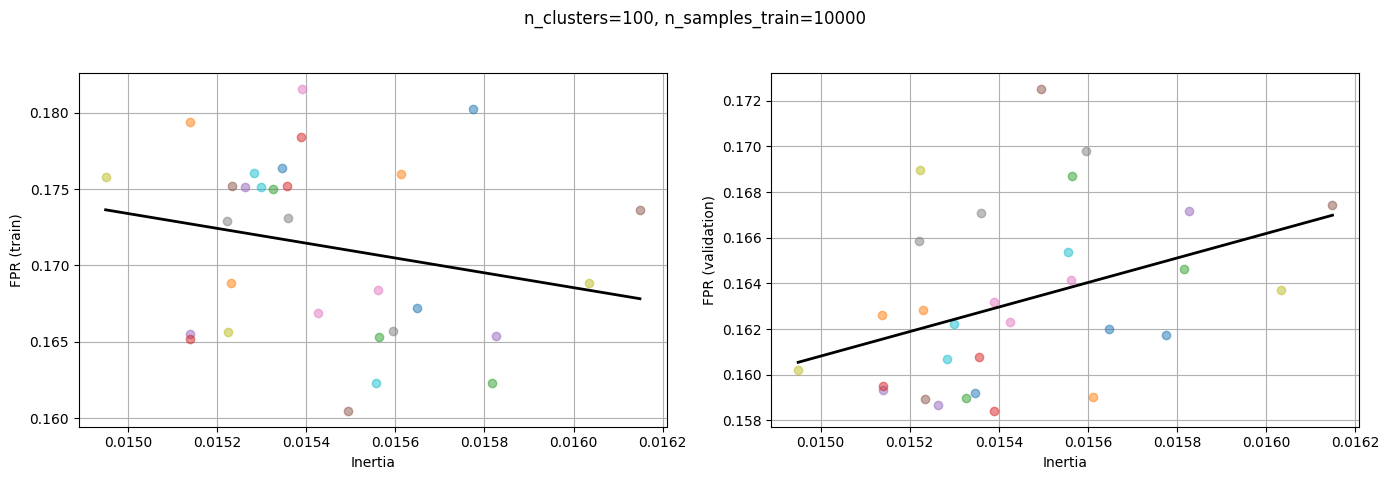

In [38]:
plot_inertia(
    df,
    partionning_space="true_proba_error",
    n_samples_train=10000,
    n_samples_test = 1000000,
    cluster_value=100,
    seed_test=-2,
)

**How Kmeans build its partition ?**

In [172]:
import math
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

def plot_experiment_histograms_(df, n_samples_train, n_samples_test, n_clusters, method,
                                seed_train, seed_test, partionning_space, init_scheme,
                                score_col='embs',
                                label_col='detector_labels',
                                labels=('No error', 'Error'),
                                bins=60):
    """
    Plots normalized-frequency histograms of `score_col` for label=False vs label=True
    for each experiment DataFrame in `experiment_dfs`, arranged in 2 columns.
    Each subplot is titled with its kmeans_seed.
    """
    # filter the master df
    df_c = df[(df["data_n_samples_train"] == n_samples_train) &
              (df["data_n_samples_test"] == n_samples_test) &
              (df["clustering_n_clusters"] == n_clusters) &
              (df["clustering_name"] == method) &
              (df["data_seed_train"] == seed_train) &
              (df["data_seed_test"] == seed_test) &
              (df["clustering_space"].eq(partionning_space) 
               | df["clustering_space"].isna()) &
                (df["clustering_init_scheme"] == init_scheme) 
               ]

    experiment_nbs = df_c["experiment_folder"].to_list()
    kmeans_seeds = df_c["clustering_seed"].to_list()
    # print(df_c)
    n = len(experiment_nbs)

    if n == 0:
        print("No experiments matched the given parameters.")
        return

    # compute grid size: 2 columns, rows = ceil(n/2)
    n_cols = 2
    n_rows = math.ceil(n / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows), sharey=True)
    axes = axes.flatten()

    for idx, (ax, exp_nb, seed_k) in enumerate(zip(axes, experiment_nbs, kmeans_seeds)):
        from joblib import dump, load



        # load cluster centers and training predictions
        if method == "kmeans":
            centers = pd.read_csv(
                os.path.join(RESULTS_DIR, exp_nb, "cluster_centers.csv")
            )
            centers = centers["centers"].values
            boundaries = (centers[:-1] + centers[1:]) / 2.0
            
        elif method == "soft-kmeans":
            print("jj", os.path.join(RESULTS_DIR, exp_nb, "clustering_algo.pkl"))
            clustering_algo = joblib.load(os.path.join(RESULTS_DIR, exp_nb, "clustering_algo.pkl"))
            xs = np.linspace(0, 1, 100)
            clusters = clustering_algo.predict(xs.reshape(-1, 1))
            plt.plot(xs, clusters)
            changes = np.where(clusters[:-1] != clusters[1:])[0]
            # mid-points between samples
            boundaries = (xs[changes] + xs[changes+1]) / 2
        

        exp_train_predictions = pd.read_csv(
            os.path.join(RESULTS_DIR, exp_nb, "detector_train_predictions.csv")
        )

        # define common bins
        all_scores = exp_train_predictions[score_col]
        bin_edges = np.linspace(all_scores.min(), all_scores.max(), bins)

        # split scores by true label
        scores_0 = exp_train_predictions.loc[~exp_train_predictions[label_col], score_col]
        scores_1 = exp_train_predictions.loc[exp_train_predictions[label_col], score_col]

        # plot histograms
        ax.hist(scores_0, bins=bin_edges, density=True, alpha=0.5, label=labels[0])
        ax.hist(scores_1, bins=bin_edges, density=True, alpha=0.5, label=labels[1])

        # add cluster boundaries
        boundaries = np.concatenate(([0.0], boundaries, [1.0]))
        for b in boundaries:
            ax.axvline(b, color='k', linestyle='--', linewidth=1.2)

        # title with kmeans_seed
        fpr_val = df_c[df_c["experiment_folder"] == exp_nb]["fpr_val"].item()
        ax.set_title(f'kmeans_seed = {seed_k} - FPR = {fpr_val:.3f}')
        ax.set_xlabel('Detection Score')
        if idx % n_cols == 0:
            ax.set_ylabel('Normalized Frequency')
        ax.legend(title='True Label')
        ax.grid(True)

    # turn off unused subplots
    for j in range(n, len(axes)):
        fig.delaxes(axes[j])
    fig.suptitle(f'n_clusters={n_clusters}, n_samples_train={n_samples_train}')
    plt.tight_layout()
    plt.show()




In [231]:
df

,data_n_samples_train,data_n_samples_test,data_batch_size_train,data_batch_size_test,data_seed_train,data_seed_test,clustering_name,clustering_n_clusters,clustering_seed,clustering_init_scheme,...,experiment_folder,fpr_train,tpr_train,thr_train,fpr_val,tpr_val,thr_val,inertia,clustering_temperature,clustering_normalize_gini
0,500,100000,100000,100000,2,-1,soft-kmeans,20.0,0.0,kmeans++,...,experiment_5350,0.134904,0.969697,0.403681,0.171576,0.960977,0.375663,3.237296,NaN,NaN
1,77000,100000,100000,100000,3,-1,uniform,500.0,NaN,None,...,experiment_1038,0.166798,0.951185,0.121231,0.152835,0.950825,0.127240,NaN,NaN,None
2,200,100000,100000,100000,8,-1,kmeans,5.0,0.0,k-means++,...,experiment_7040,0.176471,1.000000,0.417327,1.000000,1.000000,0.109439,0.234231,NaN,NaN
3,84000,100000,100000,100000,1,-1,kmeans,50.0,0.0,k-means++,...,experiment_4121,0.165898,0.950631,0.079339,0.163027,0.957170,0.079339,0.598178,NaN,None
4,14000,100000,100000,100000,2,-1,soft-kmeans,5.0,0.0,kmeans,...,experiment_5170,0.182368,0.957128,0.115351,0.177500,0.963357,0.115351,3.067385,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7252,5000,100000,100000,100000,7,-1,soft-kmeans,20.0,0.0,kmeans++,...,experiment_5436,0.208262,0.980263,0.098305,0.203883,0.971447,0.098305,3.127261,NaN,NaN
7253,370000,100000,100000,100000,1,-1,kmeans,100.0,0.0,k-means++,...,experiment_1424,0.159076,0.950181,0.066204,0.157456,0.953363,0.066204,0.633781,NaN,None
7254,73000,100000,100000,100000,2,-1,kmeans,20.0,0.0,k-means++,...,experiment_3242,0.191438,0.964301,0.056234,0.189603,0.967481,0.056234,3.233184,NaN,None
7255,20000,100000,100000,100000,8,-1,soft-kmeans,5.0,0.0,kmeans++,...,experiment_6599,0.180432,0.963855,0.103055,0.175845,0.962405,0.103055,3.060234,NaN,NaN


In [ ]:
import math
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

def plot_experiment_histograms_(
    df,
    n_samples_train,
    n_samples_test,
    n_clusters,
    seed_train,
    seed_test,
    partionning_space,
    init_scheme,
    methods=("kmeans", "soft-kmeans"),
    clustering_seed={"kmeans": 0, "soft-kmeans": 0},
    score_col='embs',
    label_col='detector_labels',
    labels=('No error', 'Error'),
    bins=60
):
    """
    Plots side-by-side normalized-frequency histograms of `score_col` for two clustering methods.

    Each subplot shows label=False vs label=True under the two methods.

    Main title indicates n_clusters, n_samples_train, and train_seed.

    Parameters
    ----------
    df : pandas.DataFrame
        Must contain columns ['data_n_samples_train','data_n_samples_test','clustering_n_clusters',
        'clustering_name','data_seed_train','data_seed_test','clustering_space',
        'clustering_init_scheme','clustering_seed','experiment_folder','fpr_val']
    n_samples_train : int
    n_samples_test  : int
    n_clusters      : int
    seed_train      : int
    seed_test       : int
    partionning_space : str
    init_scheme     : dict
        Mapping method -> init scheme string
    methods : tuple of str
        Two methods to compare
    clustering_seed : dict
        Mapping method -> clustering seed
    score_col : str
    label_col : str
    labels    : tuple of str
    bins      : int
    """
    # Prepare figure
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), sharey=True)

    for ax, method in zip(axes, methods):
        # Filter for this method
        df_c = df[
            (df['data_n_samples_train'] == n_samples_train) &
            (df['data_n_samples_test'] == n_samples_test) &
            (df['clustering_n_clusters'] == n_clusters) &
            (df['clustering_name'] == method) &
            (df['data_seed_train'] == seed_train) &
            (df['data_seed_test'] == seed_test) &
            ((df['clustering_space'] == partionning_space) | df['clustering_space'].isna()) &
            (df['clustering_init_scheme'] == init_scheme[method]) &
            (df['clustering_seed'] == clustering_seed[method])
        ]

        if df_c.empty:
            ax.text(0.5, 0.5, f"No data for {method}", ha='center')
            continue

        exp_nb = df_c['experiment_folder'].iloc[0]
        fpr_val = df_c['fpr_val'].iloc[0]
        threshold = df_c['thr_val'].iloc[0]

        # Load cluster boundaries
        if method == 'kmeans':
            centers = pd.read_csv(os.path.join(RESULTS_DIR, exp_nb, 'cluster_centers.csv'))['centers'].values
            boundaries = (centers[:-1] + centers[1:]) / 2.0
        else:  # soft-kmeans
            clustering_algo = joblib.load(os.path.join(RESULTS_DIR, exp_nb, 'clustering_algo.pkl'))
            xs = np.linspace(0, 1, 100)
            clusters = clustering_algo.predict(xs.reshape(-1, 1))
            changes = np.where(clusters[:-1] != clusters[1:])[0]
            boundaries = (xs[changes] + xs[changes + 1]) / 2.0

        # Load predictions
        preds = pd.read_csv(os.path.join(RESULTS_DIR, exp_nb, 'detector_train_predictions.csv'))
        all_scores = preds[score_col]
        bin_edges = np.linspace(all_scores.min(), all_scores.max(), bins)
        scores_0 = preds.loc[~preds[label_col], score_col]
        scores_1 = preds.loc[preds[label_col], score_col]

        # Plot histograms
        ax.hist(scores_0, bins=bin_edges, density=True, alpha=0.5, label=labels[0])
        ax.hist(scores_1, bins=bin_edges, density=True, alpha=0.5, label=labels[1])

        # Draw boundaries
        boundaries_full = np.concatenate(([0.0], boundaries, [1.0]))
        print(boundaries_full)
        for b in boundaries_full:
            ax.axvline(b, color='k', linestyle='--', linewidth=1.2)

        ax.axvline(threshold, color='orange', linestyle='--', linewidth=1.2, label='Threshold Val')
        # Decorations
        ax.set_title(f"{method} - FPR val = {fpr_val:.3f}")
        ax.set_xlabel('Detection Score')
        ax.set_ylabel('Normalized Frequency')
        ax.legend(title='True Label')
        ax.grid(True)

    # Main title
    fig.suptitle(f"n_clusters={n_clusters}, n_samples_train={n_samples_train}, train_seed={seed_train}")
    plt.tight_layout(rect=[0, 0, 1, 0.94])
    plt.legend()
    plt.show()


In [59]:
cluster_centers = pd.read_csv(os.path.join(RESULTS_DIR, "experiment_7087", 'cluster_centers.csv'))
cluster_centers

,cluster,centers
0,0,0.007097
1,3,0.188592
2,2,0.442147
3,4,0.752835
4,1,0.974850


In [66]:
train_preds = pd.read_csv(os.path.join(RESULTS_DIR, "experiment_7087", 'detector_val_predictions.csv'))
val_preds = pd.read_csv(os.path.join(RESULTS_DIR, "experiment_7087", 'detector_val_predictions.csv'))
arg_sort = [0, 3, 2, 4, 1]
cluster_counts = val_preds["clusters"].value_counts(dropna=False).values[arg_sort]
print("count per cluster", cluster_counts)
train_preds["clusters"].value_counts(dropna=False)

print("n_sample", val_preds.shape[0])

n_negatif_total = (val_preds["detector_labels"] == False).sum()
n_positif_total = (val_preds["detector_labels"] == True).sum()
print("n_negatif_total", n_negatif_total)
print("n_positif_total", n_positif_total)
negatifs_per_cluster = np.array([val_preds[
    (val_preds["detector_labels"] == False) & (val_preds["clusters"] == i)].shape[0] for i in range(5)])[arg_sort]

print(negatifs_per_cluster)


[np.sum(negatifs_per_cluster[i:]) for i in range(5)] / n_negatif_total

count per cluster [85277  1512  3951  1326  7934]
n_sample 100000
n_negatif_total 93696
n_positif_total 6304
[84597  6414  2283   372    30]


array([1.00000000e+00, 9.71119365e-02, 2.86565061e-02, 4.29047131e-03,
       3.20184426e-04])

In [40]:
cluster_counts[0]

85277

In [42]:
85277 /93696

0.9101455771857924

In [41]:
n_negatif_total

93696

In [39]:
cluster_counts[:1] /n_negatif_total

array([0.91014558])

In [8]:
df[(df["clustering_n_clusters"] == 5) & (df["clustering_name"] == "kmeans")]["clustering_name"].value_counts(dropna=False)

cluster_values = [5]
seed_test = -1
init_scheme = {"kmeans" : "k-means++", "soft-kmeans" : "kmeans++"}
n_samples_train_inf = 800
n_samples_train_sup = 800
clustering_seed = {"kmeans" : 0, "soft-kmeans" : 0}
clustering_space = "true_proba_error"
methods=["kmeans", "kmeans"]

method = "kmeans"
df_c = df[
    (df['clustering_n_clusters'] == cluster_values[0]) &
    (df['data_n_samples_train'] >= n_samples_train_inf) &
    (df['data_n_samples_train'] <= n_samples_train_sup) &
    # df['fpr_val'].notnull() &
    (df['data_seed_test'] == seed_test) &
    (df['clustering_name'] == method) &
#    ( df["clustering_space"].eq(partionning_space) 
#     | df["clustering_space"].isna()) &
    (df['clustering_init_scheme'] == init_scheme[method]) &
    (df['clustering_seed'] == clustering_seed[method])
    ]
df_c

,data_n_samples_train,data_n_samples_test,data_batch_size_train,data_batch_size_test,data_seed_train,data_seed_test,clustering_name,clustering_n_clusters,clustering_seed,clustering_init_scheme,...,experiment_folder,fpr_train,tpr_train,thr_train,fpr_val,tpr_val,thr_val,inertia,clustering_temperature,clustering_normalize_gini
2231,800,100000,100000,100000,3,-1,kmeans,5.0,0.0,k-means++,...,experiment_7089,0.114058,0.956522,0.313962,1.0,1.0,0.055453,0.632288,NaN,NaN
2927,800,100000,100000,100000,4,-1,kmeans,5.0,0.0,k-means++,...,experiment_7090,1.000000,1.000000,0.061214,1.0,1.0,0.061214,0.599470,NaN,NaN
4582,800,100000,100000,100000,1,-1,kmeans,5.0,0.0,k-means++,...,experiment_7087,1.000000,1.000000,0.062215,1.0,1.0,0.062215,0.649570,NaN,NaN
4615,800,100000,100000,100000,6,-1,kmeans,5.0,0.0,k-means++,...,experiment_7092,1.000000,1.000000,0.060856,1.0,1.0,0.060856,0.591226,NaN,NaN
4722,800,100000,100000,100000,7,-1,kmeans,5.0,0.0,k-means++,...,experiment_7093,1.000000,1.000000,0.057223,1.0,1.0,0.057223,0.573588,NaN,NaN
4805,800,100000,100000,100000,9,-1,kmeans,5.0,0.0,k-means++,...,experiment_7095,1.000000,1.000000,0.058152,1.0,1.0,0.058152,0.633338,NaN,NaN
5576,800,100000,100000,100000,8,-1,kmeans,5.0,0.0,k-means++,...,experiment_7094,0.134667,0.980000,0.293931,1.0,1.0,0.054808,0.670095,NaN,NaN
5658,800,100000,100000,100000,5,-1,kmeans,5.0,0.0,k-means++,...,experiment_7091,1.000000,1.000000,0.058322,1.0,1.0,0.058322,0.689392,NaN,NaN
6344,800,100000,100000,100000,2,-1,kmeans,5.0,0.0,k-means++,...,experiment_7088,0.120850,0.957447,0.278505,1.0,1.0,0.055717,0.601556,NaN,NaN


jj ../../synth_results/asymp_exp/experiment_6835/clustering_algo.pkl


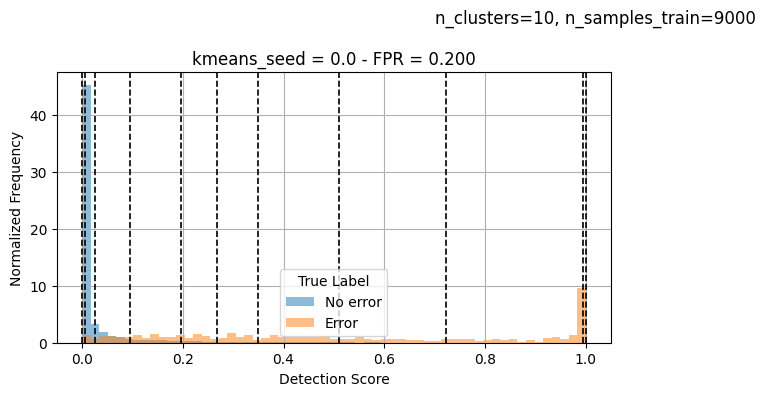

In [ ]:
partionning_space= "true_proba_error"
n_samples_train=900
n_samples_test=100000
n_clusters=10

seed_train=1
seed_test=-1
init_scheme = "kmeans++"

clustering_space = "true_proba_error"
method= "soft-kmeans"


plot_experiment_histograms_(
    df,
    n_samples_train=n_samples_train,
    n_samples_test=n_samples_test,
    n_clusters=n_clusters,
    method=method,
    seed_train=seed_train,
    seed_test=seed_test,
    partionning_space= partionning_space,
    init_scheme=init_scheme
)


**n_cluster = 5 :  Why kmeans does not work ?**

[0.         0.09784445 0.3153696  0.59749082 0.86384215 1.        ]
[0.         0.00505051 0.06565657 0.6010101  0.95454545 1.        ]


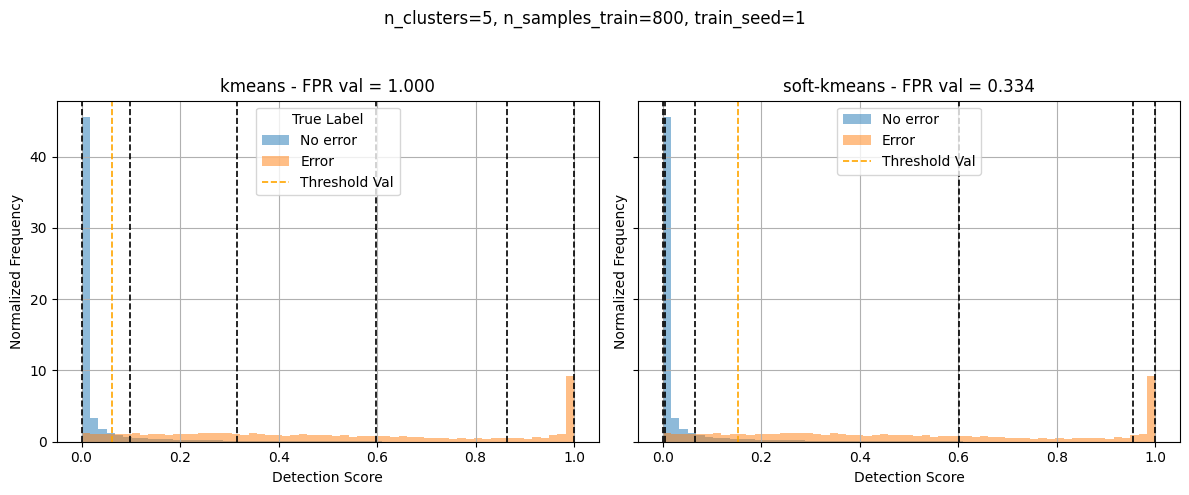

In [7]:
partionning_space= "true_proba_error"
n_samples_train=800
n_samples_test=100000
n_clusters=5

seed_train=1
seed_test=-1
init_scheme = {"kmeans" : "k-means++", "soft-kmeans" : "kmeans++"}

clustering_seed = {"kmeans" : 0, "soft-kmeans" : 0}
clustering_space = "true_proba_error"
method=["kmeans", "soft-kmeans"]


plot_experiment_histograms_(
    df,
    n_samples_train=n_samples_train,
    n_samples_test=n_samples_test,
    n_clusters=n_clusters,
    methods=method,
    seed_train=seed_train,
    seed_test=seed_test,
    partionning_space= partionning_space,
    init_scheme=init_scheme,
    clustering_seed=clustering_seed
)



**n_cluster = 10**

[0.         0.02536137 0.09054836 0.17584329 0.25562039 0.33775988
 0.44671381 0.6091493  0.7829007  0.92141038 1.        ]
[0.         0.00505051 0.05555556 0.20707071 0.26767677 0.35858586
 0.41919192 0.68181818 0.71212121 0.72222222 0.96464646 1.        ]


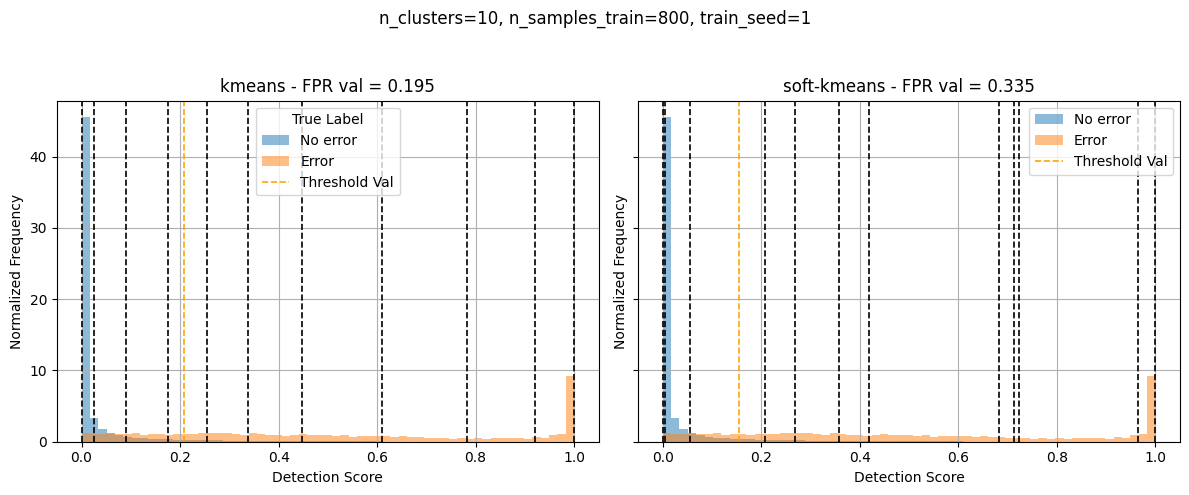

[0.         0.01460881 0.04975783 0.09974984 0.16342872 0.26815835
 0.40230479 0.56075721 0.74108471 0.89832073 1.        ]
[0.         0.00505051 0.02525253 0.10606061 0.14646465 0.21717172
 0.38888889 0.6010101  0.77272727 0.88383838 1.        ]


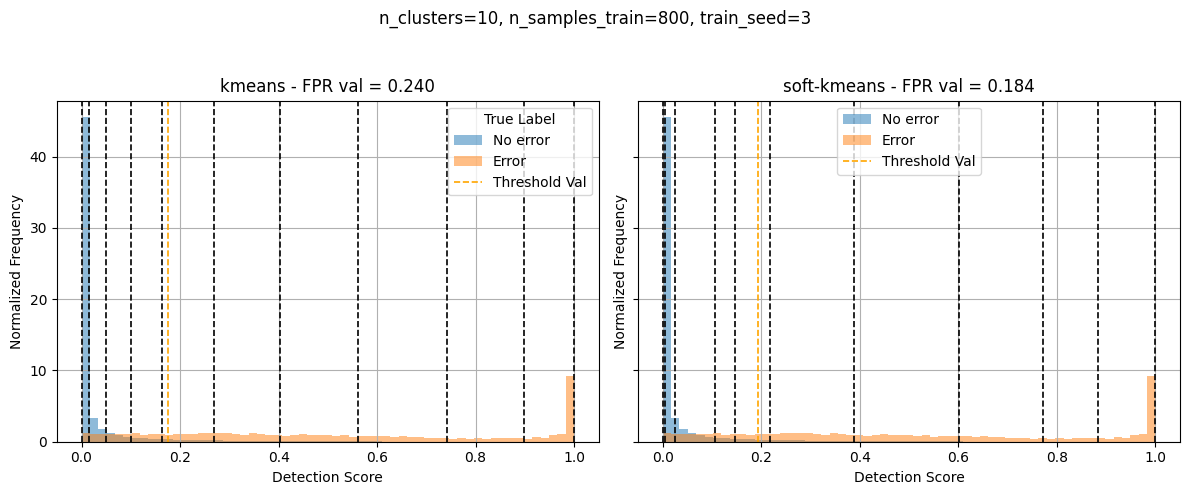

In [238]:
partionning_space= "true_proba_error"
n_samples_train=800
n_samples_test=100000
n_clusters=10

seed_train=1
seed_test=-1
init_scheme = {"kmeans" : "k-means++", "soft-kmeans" : "kmeans++"}

clustering_seed = {"kmeans" : 0, "soft-kmeans" : 0}
clustering_space = "true_proba_error"
method=["kmeans", "soft-kmeans"]


plot_experiment_histograms_(
    df,
    n_samples_train=n_samples_train,
    n_samples_test=n_samples_test,
    n_clusters=n_clusters,
    methods=method,
    seed_train=seed_train,
    seed_test=seed_test,
    partionning_space= partionning_space,
    init_scheme=init_scheme,
    clustering_seed=clustering_seed
)

plot_experiment_histograms_(
    df,
    n_samples_train=n_samples_train,
    n_samples_test=n_samples_test,
    n_clusters=n_clusters,
    methods=method,
    seed_train=3,
    seed_test=seed_test,
    partionning_space= partionning_space,
    init_scheme=init_scheme,
    clustering_seed=clustering_seed
)

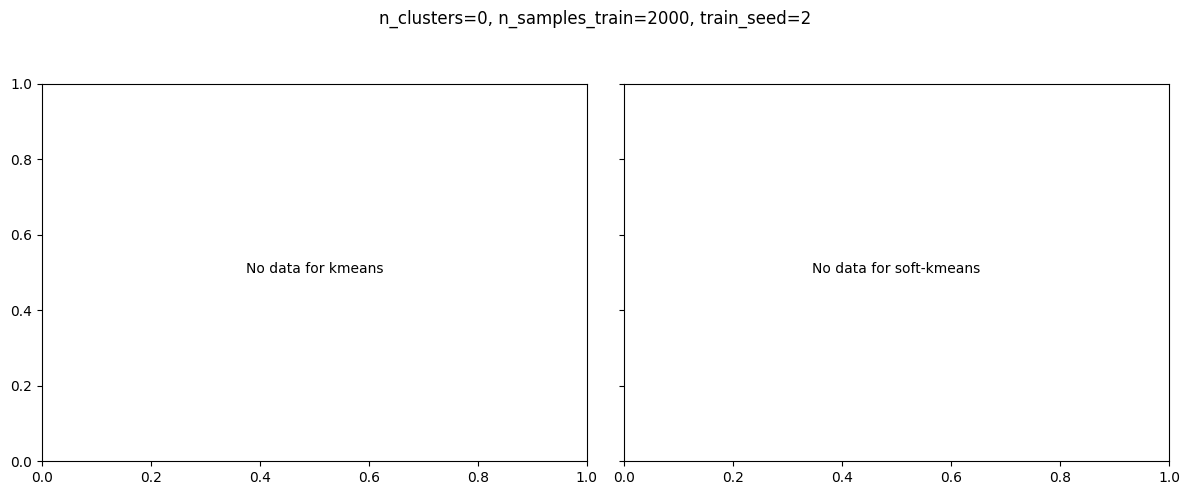

In [226]:
partionning_space= "true_proba_error"
n_samples_train=2000
n_samples_test=100000
n_clusters=0

seed_train=2
seed_test=-1
init_scheme = {"kmeans" : "k-means++", "soft-kmeans" : "kmeans++"}

clustering_seed = {"kmeans" : 0, "soft-kmeans" : 0}
clustering_space = "true_proba_error"
method=["kmeans", "soft-kmeans"]


plot_experiment_histograms_(
    df,
    n_samples_train=n_samples_train,
    n_samples_test=n_samples_test,
    n_clusters=n_clusters,
    methods=method,
    seed_train=seed_train,
    seed_test=seed_test,
    partionning_space= partionning_space,
    init_scheme=init_scheme,
    clustering_seed=clustering_seed
)


In [197]:
plot_experiment_histograms_(
    df,
    n_samples_train=12000,
    n_samples_test=100000,
    n_clusters=10,
    method="soft-kmeans",
    seed_train=1,
    seed_test=-1,
    partionning_space="true_proba_error"
)


TypeError: plot_experiment_histograms_() got an unexpected keyword argument 'method'

In [136]:

n_samples_train=12000,
n_samples_test=100000,
n_clusters=10.0,
method="soft-kmeans"
seed_train=1,
seed_test=-1,
partionning_space="true_proba_error"
labels=('No error', 'Error')

df_c = df[
    (df["data_n_samples_train"] == n_samples_train) &
              (df["data_n_samples_test"] == n_samples_test) &
              (df["clustering_n_clusters"] == n_clusters) &
              df["clustering_name"].eq(method) &
              (df["data_seed_train"] == seed_train) &
              (df["data_seed_test"] == seed_test) &
              (df["clustering_space"].eq(partionning_space))
               ]
df_c
# exp_nb =df_c["experiment_folder"].item()


# exp_train_predictions = pd.read_csv(
#             os.path.join(RESULTS_DIR, exp_nb, "detector_train_predictions.csv")
#         )

# pkl_path = os.path.join(RESULTS_DIR, exp_nb, "clustering_algo.pkl")
# print("Exists:", os.path.exists(pkl_path))
# print("Size (bytes):", os.path.getsize(pkl_path))
# from joblib import dump, load


# clustering_algo = load(pkl_path)
# xs = np.linspace(0, 1, 100)
# clusters = clustering_algo.predict(xs.reshape(-1, 1))
# plt.plot(xs, clusters)
# changes = np.where(clusters[:-1] != clusters[1:])[0]
# # mid-points between samples
# boundaries = (xs[changes] + xs[changes+1]) / 2
# for b in boundaries:
#     plt.axvline(b, color='k', linestyle='--', linewidth=1.2)
# # # with open(os.path.join(RESULTS_DIR, exp_nb, "clustering_algo.pkl"), "rb") as f:
# # #     clustering_algo = pickle.load(f)

# # bins = 30
# # # define common bins
# # score_col = "embs"
# # label_col = "detector_labels"
# # all_scores = exp_train_predictions[score_col]
# # bin_edges = np.linspace(all_scores.min(), all_scores.max(), bins)

# # # split scores by true label
# # scores_0 = exp_train_predictions.loc[~exp_train_predictions[label_col], score_col]
# # scores_1 = exp_train_predictions.loc[exp_train_predictions[label_col], score_col]

# # # plot histograms
# # plt.hist(scores_0, bins=bin_edges, density=True, alpha=0.5, label=labels[0])
# # plt.hist(scores_1, bins=bin_edges, density=True, alpha=0.5, label=labels[1])
# # plt.legend()
# # plt.show()

,data_n_samples_train,data_n_samples_test,data_batch_size_train,data_batch_size_test,data_seed_train,data_seed_test,clustering_name,clustering_n_clusters,clustering_seed,clustering_init_scheme,clustering_space,clustering_cov_type,clustering_temperature,clustering_normalize_gini,experiment_datetime,experiment_folder,fpr_train,tpr_train,thr_train,fpr_val,tpr_val,thr_val,inertia
2569,12000,100000,100000,100000,1,-1,soft-kmeans,10.0,0.0,kmeans,true_proba_error,spherical,NaN,NaN,2025-04-23_17-22-08,experiment_4894,0.214425,0.97619,0.080133,0.211044,0.973826,0.080133,3.14316


**n_cluster =2**

      data_n_samples_train  data_n_samples_test  data_batch_size_train  \
3189                  9000               100000                 100000   

      data_batch_size_test  data_seed_train  data_seed_test clustering_name  \
3189                100000                4              -1          kmeans   

      clustering_n_clusters  clustering_seed clustering_init_scheme  ...  \
3189                    2.0              0.0              k-means++  ...   

     experiment_folder fpr_train tpr_train thr_train  fpr_val  tpr_val  \
3189   experiment_4820       1.0       1.0  0.039029      1.0      1.0   

       thr_val    inertia  clustering_temperature  clustering_normalize_gini  
3189  0.039029  61.686474                     NaN                       None  

[1 rows x 23 columns]


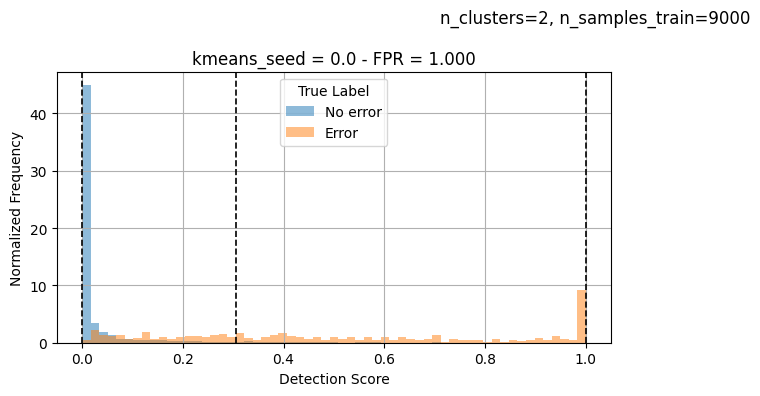

In [154]:
plot_experiment_histograms_(
    df,
    n_samples_train=9000,
    n_samples_test=100000,
    n_clusters=2,
    method="kmeans",
    seed_train=4,
    seed_test=-1,
    partionning_space="true_proba_error"
)


**n_sample == 10**

      data_n_samples_train  data_n_samples_test  data_batch_size_train  \
2680                   300               100000                 100000   

      data_batch_size_test  data_seed_train  data_seed_test clustering_name  \
2680                100000                4              -1          kmeans   

      clustering_n_clusters  clustering_seed clustering_init_scheme  ...  \
2680                   20.0              0.0              k-means++  ...   

     experiment_folder fpr_train tpr_train thr_train  fpr_val   tpr_val  \
2680   experiment_7126  0.174377       1.0  0.402025  0.21462  0.975095   

      thr_val   inertia  clustering_temperature  clustering_normalize_gini  
2680  0.35066  0.006633                     NaN                        NaN  

[1 rows x 23 columns]


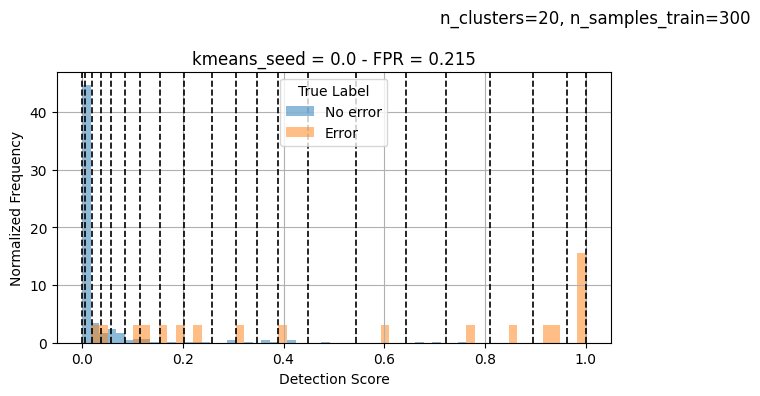

      data_n_samples_train  data_n_samples_test  data_batch_size_train  \
1382                   300               100000                 100000   

      data_batch_size_test  data_seed_train  data_seed_test clustering_name  \
1382                100000                4              -1     soft-kmeans   

      clustering_n_clusters  clustering_seed clustering_init_scheme  ...  \
1382                   20.0              0.0               kmeans++  ...   

     experiment_folder fpr_train tpr_train thr_train   fpr_val   tpr_val  \
1382   experiment_5334  0.174377       1.0  0.434396  0.210436  0.973509   

      thr_val   inertia  clustering_temperature  clustering_normalize_gini  
1382  0.37667  3.117204                     NaN                        NaN  

[1 rows x 23 columns]
jj ../../synth_results/asymp_exp/experiment_5334/clustering_algo.pkl


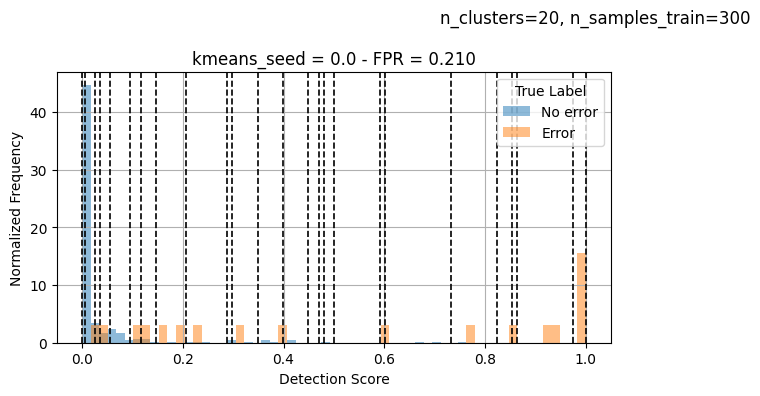

In [155]:
plot_experiment_histograms_(
    df,
    n_samples_train=300,
    n_samples_test=100000,
    n_clusters=20,
    method="kmeans",
    seed_train=4,
    seed_test=-1,
    partionning_space="true_proba_error"
)

plot_experiment_histograms_(
    df,
    n_samples_train=300,
    n_samples_test=100000,
    n_clusters=20,
    method="soft-kmeans",
    seed_train=4,
    seed_test=-1,
    partionning_space="true_proba_error"
)


In [78]:
pd.set_option('display.max_columns', None)   # show all columns
pd.set_option('display.width', 0)    
print(df[
    (df["clustering_name"] == "kmeans") & 
    (df["clustering_n_clusters"] == 20) &
    (df["data_n_samples_train"] == 10000) &
    (df["data_seed_train"] == 4)
    
    ])

      data_n_samples_train  data_n_samples_test  data_batch_size_train  \
160                  10000               100000                 100000   
317                  10000               100000                 100000   
823                  10000               100000                 100000   
1478                 10000               100000                 100000   
3490                 10000               100000                 100000   

      data_batch_size_test  data_seed_train  data_seed_test clustering_name  \
160                 100000                4              -1          kmeans   
317                 100000                4              -1          kmeans   
823                 100000                4              -1          kmeans   
1478                100000                4              -1          kmeans   
3490                100000                4              -1          kmeans   

      clustering_n_clusters  clustering_seed clustering_init_scheme  \
160      

      data_n_samples_train  data_n_samples_test  data_batch_size_train  \
1210                100000               100000                 100000   
1216                100000               100000                 100000   
4745                100000               100000                 100000   
5103                100000               100000                 100000   

      data_batch_size_test  data_seed_train  data_seed_test clustering_name  \
1210                100000                4              -1          kmeans   
1216                100000                4              -1          kmeans   
4745                100000                4              -1          kmeans   
5103                100000                4              -1          kmeans   

      clustering_n_clusters  clustering_seed clustering_init_scheme  ...  \
1210                   20.0              4.0              k-means++  ...   
1216                   20.0              3.0              k-means++  ...   
4745 

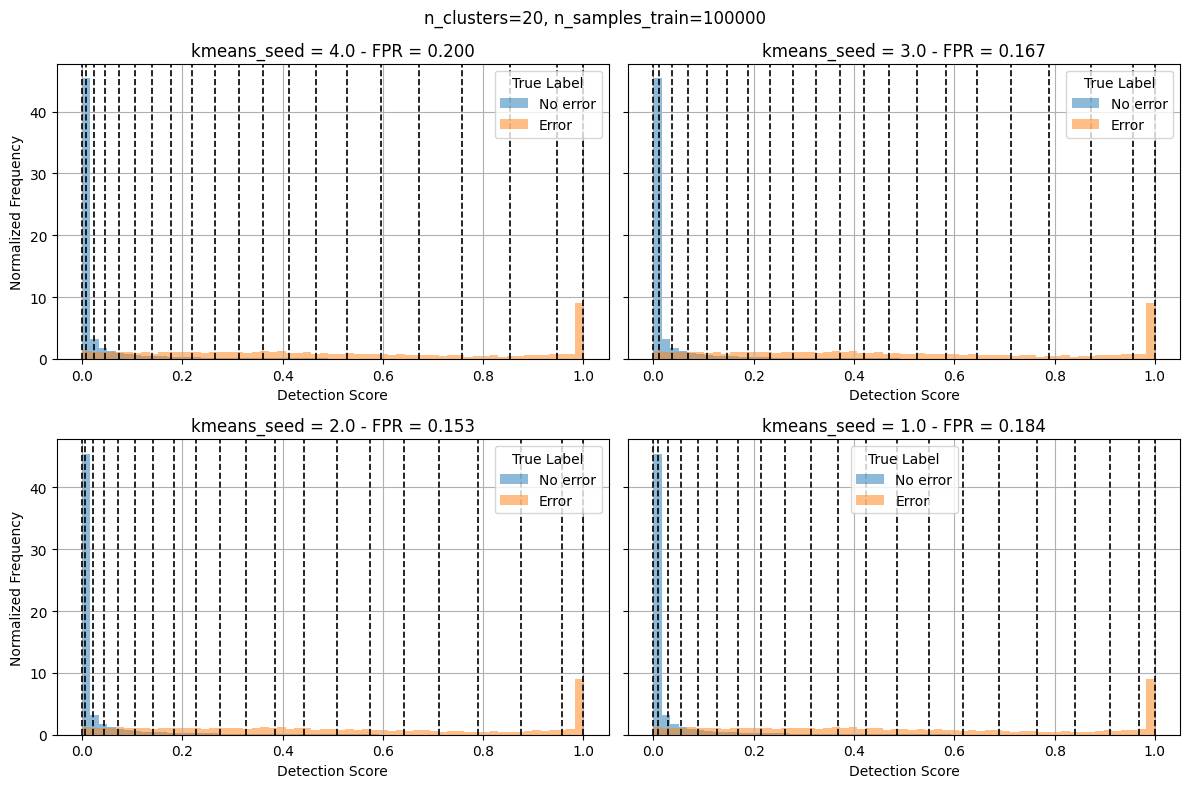

In [27]:
# plot_experiment_histograms_(
#     df,
#     n_samples_train=1000,
#     n_samples_test=100000,
#     n_clusters=20,
#     method="kmeans",
#     seed_train=4,
#     seed_test=-1,
#     partionning_space="true_proba_error"
# )

# plot_experiment_histograms_(
#     df,
#     n_samples_train=10000,
#     n_samples_test=100000,
#     n_clusters=20,
#     method="kmeans",
#     seed_train=4,
#     seed_test=-1,
#     partionning_space="true_proba_error"
# )

plot_experiment_histograms_(
    df,
    n_samples_train=100000,
    n_samples_test=100000,
    n_clusters=20,
    method="kmeans",
    seed_train=4,
    seed_test=-1,
    partionning_space="true_proba_error"
)

**We now suppose that we don't have access to the true probability of error $$ \eta(x) = \mathbb{P}\{ f(x) \neq Y \}.$$**
**Insted, we approximate it with the gini index**
$$\mathrm{gini}(x) = 1 - \sum_{y \in \mathcal{Y}} P^2_{\hat{Y} \mid X}(y \mid x)$$

**Q1: Is $\mathrm{gini}(x)$ a good approximation of $\eta(x)$ ?**

In [57]:
temperature = 1
normalize_gini = False
seed_test = -1
gini_experiment = df[
    (df["clustering_name"] == "gini") & 
    (df["clustering_temperature"] == temperature) & 
    (df["clustering_normalize_gini"] == normalize_gini) &
    (df["data_seed_test"] == seed_test) 
]
bayes_experiment = df[
    (df["clustering_name"] == "bayes") &
    (df["data_seed_test"] == seed_test) 
]
print("Gini Detector FPR:", gini_experiment["fpr_val"].item())
print("Bayes Detector FPR:", bayes_experiment["fpr_val"].item())


Gini Detector FPR: 0.2999060792349727
Bayes Detector FPR: 0.151212431693989


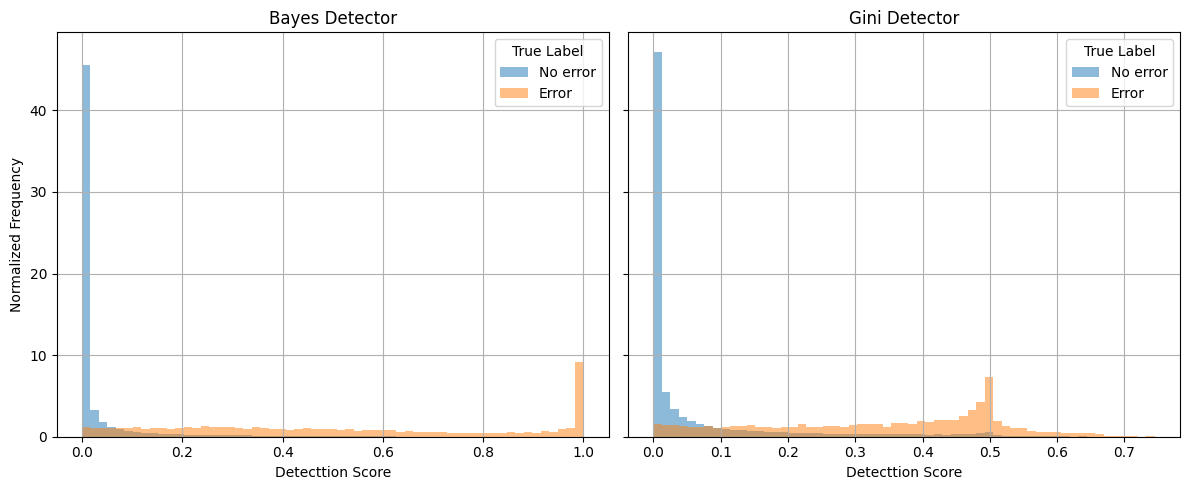

In [58]:
gini_experiment_nb = gini_experiment["experiment_folder"].item()
gini_predictions = pd.read_csv(os.path.join(RESULTS_DIR, gini_experiment_nb,"detector_predictions.csv"))


bayes_experiment_dir = bayes_experiment["experiment_folder"].item()
bayes_predictions = pd.read_csv(os.path.join(RESULTS_DIR, bayes_experiment_dir,"detector_predictions.csv"))

plot_experiment_histograms({"Bayes Detector" :bayes_predictions, "Gini Detector" :gini_predictions})

In [67]:
df["clustering_name"].value_counts(dropna=False)

clustering_name
kmeans         3710
soft-kmeans    2200
uniform        1340
gini              6
bayes             1
Name: count, dtype: int64

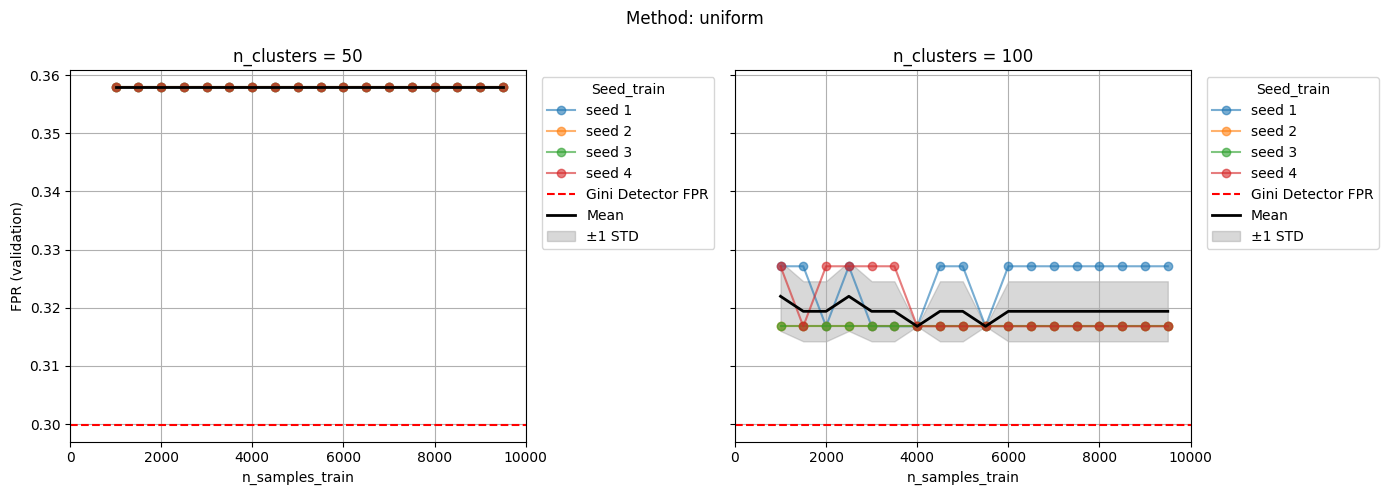

In [ ]:
plot_fpr_2(
    df,
    method="uniform",
    partionning_space="gini",
    cluster_values = [50,100],
    n_samples_train_inf=0,
    n_samples_train_sup=10000,
    seed_test=-1)

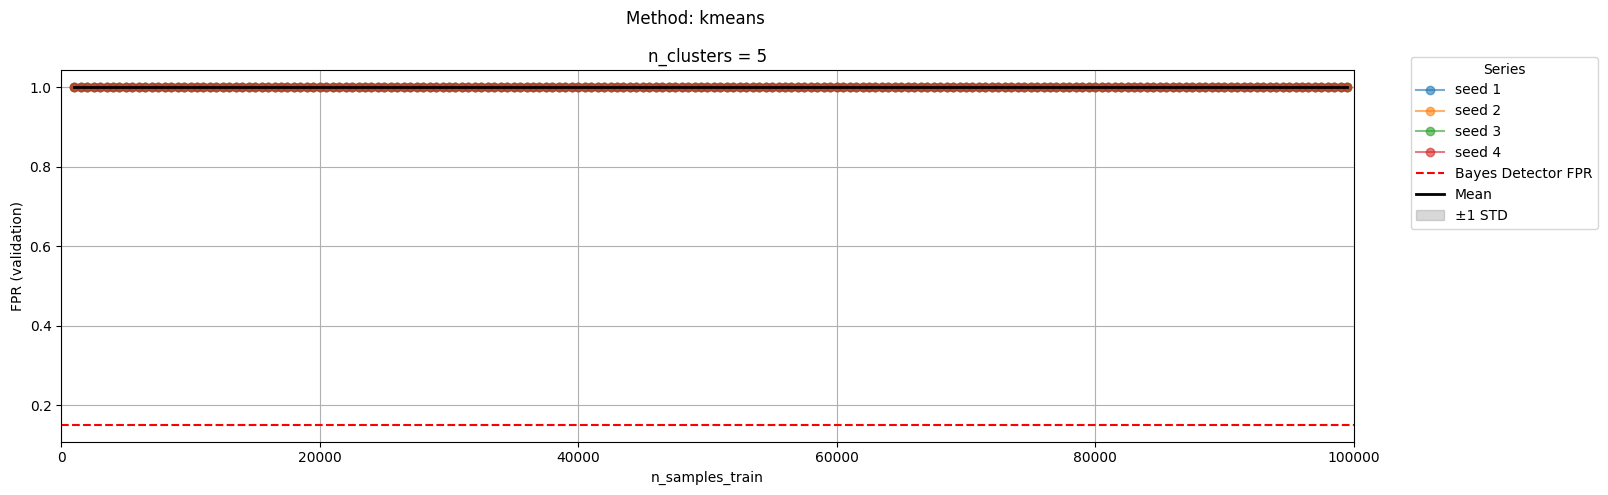

In [23]:
plot_fpr(df, seed_test=seed_test, cluster_values = [5],  method = "kmeans", n_samples_train_inf = 0, n_samples_train_sup = 100000)

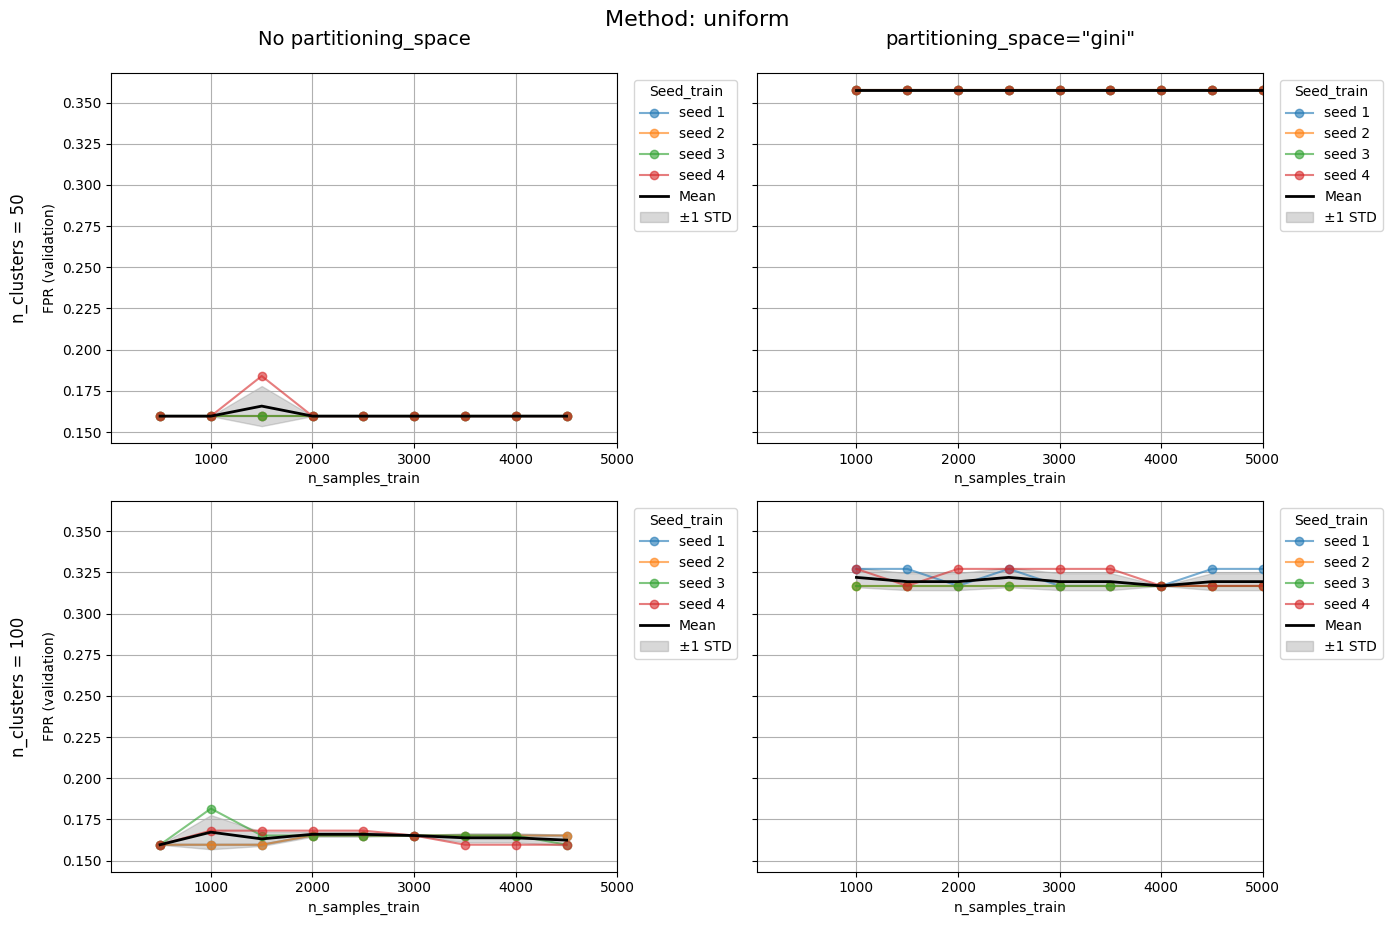

In [50]:
import numpy as np

def plot_fpr_partitioning(
    df,
    cluster_values,
    method="uniform",
    seed_test=None,
    n_samples_train_inf=None,
    n_samples_train_sup=None,
    ylim=None,
    x_interval=None
):
    """
    Plot FPR vs n_samples_train for two partitioning_space settings (NaN vs "gini")
    across multiple n_clusters, for a given method.

    Parameters
    ----------
    df : pandas.DataFrame
        Must contain columns ['n_clusters', 'n_samples_train', 'fpr_val',
        'seed_test', 'seed_train', 'method', 'partitioning_space'].
    cluster_values : list of int
        One row per cluster value.
    method : {"uniform", "kmeans"}
        Which sampling method to filter on.
    seed_test : int
        seed_test value to filter on.
    n_samples_train_inf : int
        Minimum n_samples_train to include.
    n_samples_train_sup : int
        Maximum n_samples_train to include.
    ylim : tuple or None
        Y-axis limits; e.g. (0,0.1).
    x_interval : int or None
        If provided, sets x‑axis ticks every `x_interval`.
    """
    # set up grid
    n = len(cluster_values)
    fig, axes = plt.subplots(n, 2, figsize=(14, 5*n), sharey=True)
    fig.suptitle(f"Method: {method}", fontsize=16, y=0.92)

    col_filters = [
        (df["partionning_space"].isna(),        "No partitioning_space"),
        (df["partionning_space"] == "gini",     'partitioning_space="gini"'),
    ]

    # column titles
    for j, (_, title) in enumerate(col_filters):
        axes[0, j].set_title(title, fontsize=14, pad=20)

    for i, k in enumerate(cluster_values):
        for j, (mask, _) in enumerate(col_filters):
            ax = axes[i, j]

            # filter for this cell
            df_c = df[
                (df["n_clusters"] == k) &
                (df["method"] == method) &
                mask &
                (df["seed_test"] == seed_test) &
                (df["n_samples_train"] >= n_samples_train_inf) &
                (df["n_samples_train"] <= n_samples_train_sup) &
                df["fpr_val"].notnull()
            ]

            # plot each seed_train
            for seed_train in sorted(df_c["seed_train"].unique()):
                df_s = df_c[df_c["seed_train"] == seed_train].sort_values("n_samples_train")
                ax.plot(
                    df_s["n_samples_train"],
                    df_s["fpr_val"],
                    marker="o",
                    linestyle="-",
                    alpha=0.6,
                    label=f"seed {seed_train}"
                )

            # mean ± std
            stats = (
                df_c
                .groupby("n_samples_train")["fpr_val"]
                .agg(["mean", "std"])
                .reset_index()
            )
            ax.plot(
                stats["n_samples_train"],
                stats["mean"],
                color="black",
                linewidth=2,
                label="Mean"
            )
            ax.fill_between(
                stats["n_samples_train"],
                stats["mean"] - stats["std"],
                stats["mean"] + stats["std"],
                color="gray",
                alpha=0.3,
                label="±1 STD"
            )

            # axes decor
            ax.set_xlabel("n_samples_train")
            if j == 0:
                ax.set_ylabel("FPR (validation)")
            ax.set_xlim(n_samples_train_inf, n_samples_train_sup)
            if ylim is not None:
                ax.set_ylim(ylim)
            ax.grid(True)

            # custom x-ticks
            if x_interval is not None:
                ticks = list(range(
                    n_samples_train_inf,
                    n_samples_train_sup + 1,
                    x_interval
                ))
                ax.set_xticks(ticks)

            # annotate row label on left
            if j == 0:
                ax.text(
                    -0.2, 0.5,
                    f"n_clusters = {k}",
                    transform=ax.transAxes,
                    rotation=90,
                    va="center",
                    fontsize=12
                )

            ax.legend(title="Seed_train", bbox_to_anchor=(1.02, 1), loc="upper left")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

plot_fpr_partitioning(
    df=df,
    cluster_values=[50, 100],
    method="uniform",
    seed_test=-1,
    n_samples_train_inf=20,
    n_samples_train_sup=5000,
    # ylim=(0.15, 0.2)
)

**Best n_cluster**

BE carefull, the test seed are not equivalent

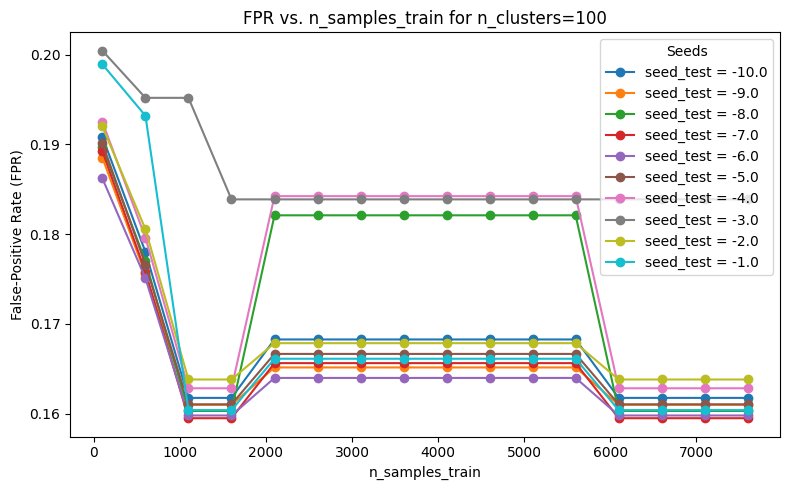

In [45]:
import matplotlib.pyplot as plt

# pick the one cluster-value you care about
cluster_value = 100

# filter down
n_samples_train_inf = 0
n_samples_train_sup = 1000000
# 1. filter out rows with n_samples_train < 1000


df_c = df[
   (df['n_clusters'] ==  cluster_value )& \
    (df['n_samples_train'] >= n_samples_train_inf) & \
    (df['n_samples_train'] <= n_samples_train_sup) & \
    df['fpr_train'].notnull() & \
    (df['seed_train'] == 1)
    ]

plt.figure(figsize=(8,5))
for seed_test in sorted(df_c['seed_test'].unique()):
    df_seed = (
        df_c[df_c['seed_test'] == seed_test]
        .sort_values('n_samples_train')
    )
    plt.plot(
        df_seed['n_samples_train'],
        df_seed['fpr_val'],
        marker='o',
        linestyle='-',
        label=f'seed_test = {seed_test}'
    )

plt.xlabel('n_samples_train')
plt.ylabel('False‑Positive Rate (FPR)')
plt.title(f'FPR vs. n_samples_train for n_clusters={cluster_value}')
plt.legend(title='Seeds')
plt.tight_layout()
plt.show()
